<h1 style="color:blue"> Project: Moving Challenge:</h1><br>
<h3 align=justify>  I am attempting to use available datasets in conjunction with Foursquare and Google API's to determine the best place to move. I am using location data from my four favorite neighborhoods in my four favorite cities: La Jolla, San Diego, CA, West Palm Beach, FL, Downtown Chicago, and Portland, Maine. I want to find the venues that best characterize a location combining attributes of each location with Foursquare. I will cluster the data from Dallas, TX, Jackxonville, FL, Chicago, IL, Austin, TX, and San Diego, CA. I will find the neighborhoods most like my ideal match. Next, a further segmentation by demographics, job availability, and income gathered from website and census data will help me choose my ideal neghborhood.  </h3>
    
    

In [46]:
#import modules and set pandas configuration
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

import re
import requests
from bs4 import BeautifulSoup

import json
from pandas.io.json import json_normalize


In [6]:
#load API keys from local file for security
with open(r'api_key.txt', 'r') as file:
    api_key = file.readline()
    CLIENT_ID = file.readline()
    CLIENT_SECRET = file.readline()
VERSION = '20180605' # Foursquare API version


<h4> Using a variety of websites I will obtain a list of neighborhoods as well as zip code and longitude/latitude data </h4

In [134]:
#url for a list of neighborhoods in San Diego
url_sandiego = r'https://en.wikipedia.org/wiki/List_of_communities_and_neighborhoods_of_San_Diego'


In [135]:
#Using Beautiful Soup, extract neighborhood list from table(pd.read_html failed) and creat a 
#neighborhood data frame
url_string=r'https://en.wikipedia.org/wiki/List_of_communities_and_neighborhoods_of_San_Diego'
page=requests.get(url_string)
page=page.text
soup=BeautifulSoup(page,features="html.parser")
results=soup.find_all("div", attrs={'style':'padding:0em 0.25em'})
neighborhood_list = []

for items in results:
    neighborhood_list.append(items.text.strip().split('\n'))
    
neighborhood_list = neighborhood_list[:-2]
neighborhood_list_2 = []

for items in neighborhood_list:
    for item in items:
        neighborhood_list_2.append(item)
        
sandiego_neighborhoods = pd.DataFrame(neighborhood_list_2, columns = ['Neighborhood'])
sandiego_neighborhoods.head()
        

,Neighborhood
0,Bay Ho
1,Bay Park
2,Carmel Valley
3,Clairemont
4,Del Mar Heights


In [136]:
sandiego_neighborhoods['Neighborhood'] = sandiego_neighborhoods['Neighborhood'].map(lambda x: x  + ', San Diego'  + ', CA')
sandiego_neighborhoods.head()


,Neighborhood
0,"Bay Ho, San Diego, CA"
1,"Bay Park, San Diego, CA"
2,"Carmel Valley, San Diego, CA"
3,"Clairemont, San Diego, CA"
4,"Del Mar Heights, San Diego, CA"


In [137]:
url_austin = r'https://en.wikipedia.org/wiki/List_of_Austin_neighborhoods'


In [138]:
table_austin = pd.read_html(url_austin)
table_austin = table_austin[0]
table_austin.drop(['COA ID#[nb 1]'], axis=1, inplace = True)
austin_neighborhoods = table_austin
austin_neighborhoods.rename(columns={'Name':'Neighborhood'}, inplace=True)
austin_neighborhoods.head()


,Neighborhood
0,Bryker Woods
1,Caswell Heights
2,Downtown Austin
3,Eastwoods
4,Hancock


In [139]:
austin_neighborhoods['Neighborhood'] = austin_neighborhoods['Neighborhood'].map(lambda x: x +', Austin, '+ 'TX')
austin_neighborhoods.head()


,Neighborhood
0,"Bryker Woods, Austin, TX"
1,"Caswell Heights, Austin, TX"
2,"Downtown Austin, Austin, TX"
3,"Eastwoods, Austin, TX"
4,"Hancock, Austin, TX"


In [140]:
url_dallas = r'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Dallas'


In [141]:
table_dallas = pd.read_html(url_dallas)
table_dallas_concat = pd.DataFrame(columns=["Neighborhood"])
for i in range(1, len(table_dallas)):
    temp_table = pd.DataFrame(table_dallas[i].iloc[:,1])
    temp_table.rename(columns={temp_table.columns[0]:"Neighborhood"}, inplace=True)
    table_dallas_concat = table_dallas_concat.append(temp_table, ignore_index=True)
    temp_table = []
dallas_neighborhoods = table_dallas_concat
dallas_neighborhoods.head()


,Neighborhood
0,Baylor District
1,The Cedars
2,Civic Center District
3,Dallas Arts District
4,Dallas Farmers Market


In [142]:
def remove_website_str(x):
    if x.startswith('website'):
        x = x.split()
        x=' '.join(x[1:])
    return x


In [143]:
dallas_neighborhood_clean = dallas_neighborhoods['Neighborhood'].apply(remove_website_str)
dallas_neighborhood_clean = pd.DataFrame(dallas_neighborhood_clean, columns = ['Neighborhood'])
dallas_neighborhood_clean.drop(index=[205, 206, 207, 208, 209], inplace = True)
dallas_neighborhood_clean.head()


,Neighborhood
0,Baylor District
1,The Cedars
2,Civic Center District
3,Dallas Arts District
4,Dallas Farmers Market


In [144]:
dallas_neighborhood_clean['Neighborhood'] = dallas_neighborhood_clean['Neighborhood'].map(lambda x: x +', Dallas, '+ 'TX')
dallas_neighborhood_clean.head()


,Neighborhood
0,"Baylor District, Dallas, TX"
1,"The Cedars, Dallas, TX"
2,"Civic Center District, Dallas, TX"
3,"Dallas Arts District, Dallas, TX"
4,"Dallas Farmers Market, Dallas, TX"


In [145]:
url_chicago = r'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago'


In [146]:
table_chicago = pd.read_html(url_chicago)
table_chicago = table_chicago[0]
table_chicago.drop(['Community area'], axis=1, inplace=True)
chicago_neighborhoods = table_chicago
chicago_neighborhoods.head()


,Neighborhood
0,Albany Park
1,Altgeld Gardens
2,Andersonville
3,Archer Heights
4,Armour Square


In [147]:
chicago_neighborhoods['Neighborhood'] = chicago_neighborhoods['Neighborhood'].map(lambda x: x +', Chicago, '+ 'IL')
chicago_neighborhoods.head()


,Neighborhood
0,"Albany Park, Chicago, IL"
1,"Altgeld Gardens, Chicago, IL"
2,"Andersonville, Chicago, IL"
3,"Archer Heights, Chicago, IL"
4,"Armour Square, Chicago, IL"


In [9]:
import re
import requests
from bs4 import BeautifulSoup


In [148]:
jacksonville_neighborhoods = pd.DataFrame(columns=['Neighborhood'])
jacksonville_neighborhoods


,Neighborhood


In [149]:
url_string=r'https://www.conservapedia.com/Neighborhoods_of_Jacksonville,_Florida'
page=requests.get(url_string)
page=page.text
soup=BeautifulSoup(page,features="html.parser")
results=soup.find_all("li", class_="toclevel-2")
for index, item in enumerate(results):
    area = item.find("span", class_="toctext").text
    jacksonville_neighborhoods = jacksonville_neighborhoods.append({'Neighborhood':area}, ignore_index=True) 
jacksonville_neighborhoods.head()



,Neighborhood
0,Argyle
1,Avondale
2,Cedar Hills
3,Confederate Point
4,Lake Shore


In [150]:
jacksonville_neighborhoods['Neighborhood'] = jacksonville_neighborhoods['Neighborhood'].map(lambda x: x +', Jacksonville, '+ 'FL')
jacksonville_neighborhoods.head()


,Neighborhood
0,"Argyle, Jacksonville, FL"
1,"Avondale, Jacksonville, FL"
2,"Cedar Hills, Jacksonville, FL"
3,"Confederate Point, Jacksonville, FL"
4,"Lake Shore, Jacksonville, FL"


In [151]:
import json
from pandas.io.json import json_normalize


In [152]:
def get_lng_lat_zip(neighborhoods):
    location_lng_lat=pd.DataFrame(columns=['Latitude', 'Longitude'])
    for i in range(len(neighborhoods)):
        url = r'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(neighborhoods['Neighborhood'][i], api_key)
        r = requests.get(url)
        json_r = json.loads(r.text)
        try:
            location_pd = json_normalize(json_r['results'])
            location_lng_lat_temp =  location_pd[['geometry.location.lat', 'geometry.location.lng']]
            location_lng_lat_temp.columns=['Latitude', 'Longitude']
            location_lng_lat = pd.concat([location_lng_lat, location_lng_lat_temp], ignore_index=True)
        except:
            continue
            
    return location_lng_lat      


In [153]:
def zip_nb(neighborhoods):
    zip_pd_temp = []
    for i in range(len(neighborhoods)):
        url_2 = 'https://maps.googleapis.com/maps/api/geocode/json?latlng={},{}&key={}'.format(neighborhoods['Latitude'][i], neighborhoods['Longitude'][i],api_key)
        r = requests.get(url_2)
        json_r = json.loads(r.text)
        location_pd_3 = json_normalize(json_r['results'][0]['address_components'])
        count=0
        for line in location_pd_3.values:
            if 'postal_code' in line[2]:
                zip_code = line[0]
                count=1
            if count != 1:
                zip_code = 'NA'    
        zip_pd_temp.append(zip_code)
        count=0
    zip_pd = pd.DataFrame(zip_pd_temp, columns = ['zip_code'])
    return(zip_pd) 


In [154]:
sandiego_neighborhoods_zip = get_lng_lat_zip(sandiego_neighborhoods)
sandiego_neighborhoods_zip.head()


,Latitude,Longitude
0,32.824243,-117.217637
1,32.791837,-117.199996
2,32.939827,-117.202936
3,32.824140,-117.193697
4,32.948378,-117.260870


In [155]:
sandiego_nb_lng_lat = pd.concat([sandiego_neighborhoods,
                                     sandiego_neighborhoods_zip],
                                    axis=1)
sandiego_nb_lng_lat.head()


,Neighborhood,Latitude,Longitude
0,"Bay Ho, San Diego, CA",32.824243,-117.217637
1,"Bay Park, San Diego, CA",32.791837,-117.199996
2,"Carmel Valley, San Diego, CA",32.939827,-117.202936
3,"Clairemont, San Diego, CA",32.824140,-117.193697
4,"Del Mar Heights, San Diego, CA",32.948378,-117.260870


In [464]:
sandiego_zip_pd = zip_nb(sandiego_nb_lng_lat)
sandiego_zip_pd.head()


,zip_code
0,92117
1,92117
2,92130
3,92117
4,92014


In [485]:
sandiego_zip_lng_lat = pd.concat([sandiego_nb_lng_lat,
                                     sandiego_zip_pd],
                                    axis=1)
sandiego_zip_lng_lat.head()


,Neighborhood,Latitude,Longitude,zip_code
0,"Bay Ho, San Diego, CA",32.824243,-117.217637,92117
1,"Bay Park, San Diego, CA",32.791837,-117.199996,92117
2,"Carmel Valley, San Diego, CA",32.939827,-117.202936,92130
3,"Clairemont, San Diego, CA",32.824140,-117.193697,92117
4,"Del Mar Heights, San Diego, CA",32.951545,-117.252915,92014


In [156]:
jacksonville_neighborhoods_zip = get_lng_lat_zip(jacksonville_neighborhoods)
jacksonville_neighborhoods_zip.head()


,Latitude,Longitude
0,30.196921,-81.756282
1,30.296769,-81.710315
2,30.253614,-81.756138
3,30.256893,-81.736310
4,30.280630,-81.726734


In [157]:
jacksonville_nb_lng_lat = pd.concat([jacksonville_neighborhoods,
                                     jacksonville_neighborhoods_zip],
                                    axis=1)
jacksonville_nb_lng_lat.head()


,Neighborhood,Latitude,Longitude
0,"Argyle, Jacksonville, FL",30.196921,-81.756282
1,"Avondale, Jacksonville, FL",30.296769,-81.710315
2,"Cedar Hills, Jacksonville, FL",30.253614,-81.756138
3,"Confederate Point, Jacksonville, FL",30.256893,-81.736310
4,"Lake Shore, Jacksonville, FL",30.280630,-81.726734


In [33]:
jacksonville_zip_pd = zip_nb(jacksonville_nb_lng_lat)
jacksonville_zip_pd.head()


,zip_code
0,32244
1,32205
2,32210
3,32210
4,32210


In [34]:
jacksonville_zip_lng_lat = pd.concat([jacksonville_nb_lng_lat,
                                     jacksonville_zip_pd],
                                    axis=1)
jacksonville_zip_lng_lat.head()


,Neighborhood,Latitude,Longitude,zip_code
0,"Argyle, Jacksonville, FL",30.196921,-81.756282,32244
1,"Avondale, Jacksonville, FL",30.296769,-81.710315,32205
2,"Cedar Hills, Jacksonville, FL",30.253614,-81.756138,32210
3,"Confederate Point, Jacksonville, FL",30.256893,-81.736310,32210
4,"Lake Shore, Jacksonville, FL",30.280630,-81.726734,32210


In [35]:
jacksonville_zip_lng_lat.to_csv('jacksonville_zip_lng_lat.csv', index='False')


In [158]:
dallas_neighborhoods_zip = get_lng_lat_zip(dallas_neighborhood_clean)
dallas_neighborhoods_zip.head()


,Latitude,Longitude
0,32.789342,-96.779515
1,32.765124,-96.789371
2,32.774389,-96.800285
3,32.789731,-96.798262
4,32.777495,-96.789263


In [161]:
dallas_nb_lng_lat = pd.concat([dallas_neighborhood_clean,
                                     dallas_neighborhoods_zip],
                                    axis=1)
dallas_nb_lng_lat.head()


,Neighborhood,Latitude,Longitude
0,"Baylor District, Dallas, TX",32.789342,-96.779515
1,"The Cedars, Dallas, TX",32.765124,-96.789371
2,"Civic Center District, Dallas, TX",32.774389,-96.800285
3,"Dallas Arts District, Dallas, TX",32.789731,-96.798262
4,"Dallas Farmers Market, Dallas, TX",32.777495,-96.789263


In [90]:
dallas_zip_pd = zip_nb(dallas_nb_lng_lat)
dallas_zip_pd.head()


,zip_code
0,75201
1,75215
2,75202
3,75201
4,75201


In [205]:
dallas_zip_lng_lat = pd.concat([dallas_nb_lng_lat,
                                     dallas_zip_pd],
                                    axis=1)
print(dallas_zip_lng_lat.shape)
dallas_zip_lng_lat.head()


(221, 4)


,Neighborhood,Latitude,Longitude,zip_code
0,"Baylor District, Dallas, TX",32.787883,-96.798620,75201
1,"The Cedars, Dallas, TX",32.765124,-96.789371,75215
2,"Civic Center District, Dallas, TX",32.774389,-96.800285,75202
3,"Dallas Arts District, Dallas, TX",32.789731,-96.798262,75201
4,"Dallas Farmers Market, Dallas, TX",32.777495,-96.789263,75201


In [160]:
index_list = []
for i in range(206,221):
    index_list.append(int(i))
    

In [111]:
dallas_zip_lng_lat.drop(index=index_list, inplace=True)
dallas_zip_lng_lat.head()


,Neighborhood,Latitude,Longitude,zip_code
0,"Baylor District, Dallas, TX",32.787883,-96.798620,75201
1,"The Cedars, Dallas, TX",32.765124,-96.789371,75215
2,"Civic Center District, Dallas, TX",32.774389,-96.800285,75202
3,"Dallas Arts District, Dallas, TX",32.789731,-96.798262,75201
4,"Dallas Farmers Market, Dallas, TX",32.777495,-96.789263,75201


In [ ]:
dallas_zip_lng_lat.to_csv('dallas_zip_lng_lat.csv', index='False')


In [1264]:
def zip_demographics(neighborhood_zip):
    zip_list = []
    zip_list_nan = ['N/A' for i in range(37)]
    for i in range(len(neighborhood_zip)):
        url_zip = 'https://zipwho.com/?zip={}-&city=&filters=--_--_--_--&state=&mode=zip'.format(neighborhood_zip['zip_code'][i])
        headers ={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:68.0) Gecko/20100101 Firefox/68.0'}
        page=requests.get(url_zip, headers=headers)
        page=page.text
        soup=BeautifulSoup(page,features="html.parser")
        start_index = str(soup.contents[4]).index('return')
        end_index = str(soup.contents[4]).index('}')
        try:
            string_data = str(soup.contents[4])[start_index+8:end_index-4]
            string_data_split = string_data.split('\\n')
            data = string_data_split[1].split(',')
            numbers = string_data_split[0].split(',')
            zip_list.append(data)
        except:
            zip_list.append(zip_list_nan)
    zip_list_pd = pd.DataFrame(zip_list, columns = numbers)
    zip_list_pd.rename(columns ={'zip':'zip_code'}, inplace = True)
    zip_list_pd.drop(columns=['city', 'state'], inplace=True)
    return zip_list_pd


In [1265]:
jacksonville_zip_list = zip_demographics(jacksonville_zip_lng_lat)
jacksonville_zip_list.head()


NameError: name 'jacksonville_zip_lng_lat' is not defined

In [276]:
jacksonville_zip_lng_lat['zip_code'] = pd.to_numeric(jacksonville_zip_lng_lat['zip_code'])
jacksonville_zip_list['zip_code'] = pd.to_numeric(jacksonville_zip_list['zip_code'])


In [343]:
jacksonville_data_merged = pd.merge(jacksonville_zip_lng_lat, jacksonville_zip_list, right_index=True, left_index=True)
jacksonville_data_merged = jacksonville_data_merged.drop('zip_code_x', axis=1)
jacksonville_data_merged.rename(columns={'zip_code_y':'Zip Code'}, inplace=True)
jacksonville_data_merged.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Argyle, Jacksonville, FL",30.196921,-81.756282,32244,41769,59,89.6,40,21.0,49,70.9,31,5.4,43,14.0,42,25.8,40,46852,96,2.7,74,31.8,11,91.3,45,58.0,33,15.0,97,65.7,21,20.8,85,4.6,90,5.4,72
1,"Avondale, Jacksonville, FL",30.296769,-81.710315,32205,34579,35,76.4,28,20.0,34,58.0,13,5.3,33,21.7,67,33.6,70,30128,86,2.2,8,35.2,30,88.8,31,47.5,9,15.7,98,71.0,25,20.1,85,2.8,84,3.2,61
2,"Cedar Hills, Jacksonville, FL",30.253614,-81.756138,32210,39095,51,79.4,30,20.0,34,63.2,18,5.5,49,17.9,57,26.4,43,58345,98,2.5,46,33.8,20,88.9,32,54.3,21,14.1,94,65.4,21,24.3,87,2.8,84,4.9,70
3,"Confederate Point, Jacksonville, FL",30.256893,-81.736310,32210,39095,51,79.4,30,20.0,34,63.2,18,5.5,49,17.9,57,26.4,43,58345,98,2.5,46,33.8,20,88.9,32,54.3,21,14.1,94,65.4,21,24.3,87,2.8,84,4.9,70
4,"Lake Shore, Jacksonville, FL",30.280630,-81.726734,32210,39095,51,79.4,30,20.0,34,63.2,18,5.5,49,17.9,57,26.4,43,58345,98,2.5,46,33.8,20,88.9,32,54.3,21,14.1,94,65.4,21,24.3,87,2.8,84,4.9,70


In [344]:
jacksonville_filtered = jacksonville_data_merged.sort_values(by=['MedianIncome'],ascending=False)
jacksonville_filtered.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
18,"Mandarin, Jacksonville, FL",30.152750,-81.652822,32223,66079,91,146.9,73,19.6,27,82.7,72,6.4,90,37.9,87,45.3,89,25424,81,2.6,59,38.1,61,91.4,45,66.4,81,10.7,69,88.7,49,4.5,65,1.6,75,3.5,63
16,"Baymeadows, Jacksonville, FL",30.236722,-81.559158,32256,45460,67,198.0,86,20.1,36,31.9,2,4.3,4,45.2,92,49.5,92,29254,85,2.0,2,31.4,10,96.8,72,49.2,11,13.0,90,71.5,25,12.0,79,7.0,94,6.5,75
19,"Sandalwood, Jacksonville, FL",30.310517,-81.508249,32246,43672,63,90.8,41,20.9,47,69.7,28,5.5,50,17.1,54,26.8,45,36012,91,2.7,73,31.7,11,93.0,54,58.2,34,14.0,94,68.3,23,16.8,83,5.5,92,6.3,74
0,"Argyle, Jacksonville, FL",30.196921,-81.756282,32244,41769,59,89.6,40,21.0,49,70.9,31,5.4,43,14.0,42,25.8,40,46852,96,2.7,74,31.8,11,91.3,45,58.0,33,15.0,97,65.7,21,20.8,85,4.6,90,5.4,72
5,"Marietta, Jacksonville, FL",30.334397,-81.802480,32220,41622,58,82.8,33,20.3,38,85.8,84,5.7,66,6.0,4,18.7,9,10583,57,2.7,69,35.4,31,99.6,82,61.7,52,12.3,86,91.8,56,3.6,62,0.6,56,1.6,45


In [345]:
jacksonville_filtered.to_csv('jacksonville_filtered.csv')


In [490]:
dallas_zip_list = zip_demographics(dallas_zip_lng_lat)
dallas_zip_list.head()


,zip_code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,75201,56675,84,311.3,95,15.6,0,10.8,0,3.3,1,63.5,98,66.1,99,3324,27,1.6,0,30.0,7,112.0,96,31.5,1,11.6,79,68.8,23,19.4,85,2.2,80,7.6,77
1,75215,16043,0,39.4,1,25.9,93,33.6,3,4.3,4,6.4,5,17.7,6,18643,72,2.6,58,34.4,23,78.9,4,34.3,1,13.7,93,2.4,0,84.0,99,0.1,30,12.1,84
2,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
3,75201,56675,84,311.3,95,15.6,0,10.8,0,3.3,1,63.5,98,66.1,99,3324,27,1.6,0,30.0,7,112.0,96,31.5,1,11.6,79,68.8,23,19.4,85,2.2,80,7.6,77
4,75201,56675,84,311.3,95,15.6,0,10.8,0,3.3,1,63.5,98,66.1,99,3324,27,1.6,0,30.0,7,112.0,96,31.5,1,11.6,79,68.8,23,19.4,85,2.2,80,7.6,77


In [328]:
dallas_data_merged = pd.merge(dallas_zip_lng_lat, dallas_zip_list, right_index=True, left_index=True)
dallas_data_merged = dallas_data_merged.drop('zip_code_y', axis=1)
dallas_data_merged.rename(columns={'zip_code_x':'Zip Code'}, inplace=True)
dallas_data_merged.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Baylor District, Dallas, TX",32.787883,-96.798620,75201,56675,84,311.3,95,15.6,0,10.8,0,3.3,1,63.5,98,66.1,99,3324,27,1.6,0,30.0,7,112.0,96,31.5,1,11.6,79,68.8,23,19.4,85,2.2,80,7.6,77
1,"The Cedars, Dallas, TX",32.765124,-96.789371,75215,16043,0,39.4,1,25.9,93,33.6,3,4.3,4,6.4,5,17.7,6,18643,72,2.6,58,34.4,23,78.9,4,34.3,1,13.7,93,2.4,0,84.0,99,0.1,30,12.1,84
2,"Civic Center District, Dallas, TX",32.774389,-96.800285,75202,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
3,"Dallas Arts District, Dallas, TX",32.789731,-96.798262,75201,56675,84,311.3,95,15.6,0,10.8,0,3.3,1,63.5,98,66.1,99,3324,27,1.6,0,30.0,7,112.0,96,31.5,1,11.6,79,68.8,23,19.4,85,2.2,80,7.6,77
4,"Dallas Farmers Market, Dallas, TX",32.777495,-96.789263,75201,56675,84,311.3,95,15.6,0,10.8,0,3.3,1,63.5,98,66.1,99,3324,27,1.6,0,30.0,7,112.0,96,31.5,1,11.6,79,68.8,23,19.4,85,2.2,80,7.6,77


In [335]:
dallas_filter = dallas_data_merged['MedianIncome'].apply(lambda x: x != 'N/A')
dallas_filtered=dallas_data_merged[dallas_filter]
dallas_filtered.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Baylor District, Dallas, TX",32.787883,-96.798620,75201,56675,84,311.3,95,15.6,0,10.8,0,3.3,1,63.5,98,66.1,99,3324,27,1.6,0,30.0,7,112.0,96,31.5,1,11.6,79,68.8,23,19.4,85,2.2,80,7.6,77
1,"The Cedars, Dallas, TX",32.765124,-96.789371,75215,16043,0,39.4,1,25.9,93,33.6,3,4.3,4,6.4,5,17.7,6,18643,72,2.6,58,34.4,23,78.9,4,34.3,1,13.7,93,2.4,0,84.0,99,0.1,30,12.1,84
3,"Dallas Arts District, Dallas, TX",32.789731,-96.798262,75201,56675,84,311.3,95,15.6,0,10.8,0,3.3,1,63.5,98,66.1,99,3324,27,1.6,0,30.0,7,112.0,96,31.5,1,11.6,79,68.8,23,19.4,85,2.2,80,7.6,77
4,"Dallas Farmers Market, Dallas, TX",32.777495,-96.789263,75201,56675,84,311.3,95,15.6,0,10.8,0,3.3,1,63.5,98,66.1,99,3324,27,1.6,0,30.0,7,112.0,96,31.5,1,11.6,79,68.8,23,19.4,85,2.2,80,7.6,77
5,"Deep Ellum, Dallas, TX",32.784392,-96.780185,75226,38911,50,441.5,98,32.5,99,1.0,0,2.6,0,34.5,84,40.9,84,2693,20,2.5,33,29.6,6,184.3,99,45.2,7,9.0,43,37.8,8,11.4,78,1.8,77,48.5,96


In [338]:
dallas_filtered.sort_values(by=['MedianIncome'], inplace=True, ascending=False)
dallas_filtered.head()


C:\Users\gtm12\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
113,"Northwood Hills, Dallas, TX",32.863998,-96.803733,75225,98838,98,485.0,98,21.0,49,76.9,49,6.8,94,74.9,99,66.0,99,20157,74,2.3,14,41.7,88,78.4,3,65.6,77,7.9,28,95.9,72,0.0,5,0.7,58,2.2,53
12,"Uptown, Dallas, TX",32.868538,-96.773511,75225,98838,98,485.0,98,21.0,49,76.9,49,6.8,94,74.9,99,66.0,99,20157,74,2.3,14,41.7,88,78.4,3,65.6,77,7.9,28,95.9,72,0.0,5,0.7,58,2.2,53
88,"Stultz Road, Dallas, TX",32.869628,-96.793932,75225,98838,98,485.0,98,21.0,49,76.9,49,6.8,94,74.9,99,66.0,99,20157,74,2.3,14,41.7,88,78.4,3,65.6,77,7.9,28,95.9,72,0.0,5,0.7,58,2.2,53
92,"Whispering Hills, Dallas, TX",32.989294,-97.018090,75028,91855,98,179.9,83,20.3,39,92.1,97,7.3,97,51.0,94,54.5,95,36393,91,3.1,93,32.9,16,96.1,69,75.2,99,6.5,13,86.4,44,3.1,60,2.6,82,5.4,72
29,"Greenland Hills, Dallas, TX",33.051367,-97.070180,75028,91855,98,179.9,83,20.3,39,92.1,97,7.3,97,51.0,94,54.5,95,36393,91,3.1,93,32.9,16,96.1,69,75.2,99,6.5,13,86.4,44,3.1,60,2.6,82,5.4,72


In [476]:
dallas_filtered.to_csv('dallas_filtered.csv')


In [172]:
austin_neighborhoods_zip = get_lng_lat_zip(austin_neighborhoods)
austin_neighborhoods_zip.head()


,Latitude,Longitude
0,30.302450,-97.753893
1,30.307765,-97.719435
2,30.272921,-97.744386
3,30.290371,-97.726479
4,30.296469,-97.723215


In [173]:
austin_nb_lng_lat = pd.concat([austin_neighborhoods,
                                     austin_neighborhoods_zip],
                                    axis=1)
austin_nb_lng_lat.head()


,Neighborhood,Latitude,Longitude
0,"Bryker Woods, Austin, TX",30.302450,-97.753893
1,"Caswell Heights, Austin, TX",30.307765,-97.719435
2,"Downtown Austin, Austin, TX",30.272921,-97.744386
3,"Eastwoods, Austin, TX",30.290371,-97.726479
4,"Hancock, Austin, TX",30.296469,-97.723215


In [350]:
austin_zip_pd = zip_nb(austin_nb_lng_lat)
austin_zip_pd.head()


,zip_code
0,78703
1,78751
2,78701
3,78705
4,78705


In [351]:
austin_zip_lng_lat = pd.concat([austin_nb_lng_lat,
                                     austin_zip_pd],
                                    axis=1)
austin_zip_lng_lat.head()


,Neighborhood,Latitude,Longitude,zip_code
0,"Bryker Woods, Austin, TX",30.302450,-97.753893,78703
1,"Caswell Heights, Austin, TX",30.307765,-97.719435,78751
2,"Downtown Austin, Austin, TX",30.272921,-97.744386,78701
3,"Eastwoods, Austin, TX",30.290371,-97.726479,78705
4,"Hancock, Austin, TX",30.296469,-97.723215,78705


In [353]:
austin_zip_list = zip_demographics(austin_zip_lng_lat)
austin_zip_list.head()


,zip_code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,78703,54591,81,326.0,96,21.1,50,51.5,8,4.8,10,74.1,99,68.1,99,19522,73,2.0,2,34.5,25,97.7,75,50.4,13,9.7,54,81.7,36,1.5,50,6.8,93,7.6,77
1,78751,29779,18,160.5,78,23.5,80,25.9,1,3.6,1,55.3,96,49.7,92,13829,64,1.8,0,28.1,3,122.2,97,27.6,0,10.4,64,67.3,22,1.5,50,6.8,93,21.6,90
2,78701,35757,40,199.8,87,23.9,83,37.7,4,3.3,1,46.2,92,48.9,92,3780,30,2.2,6,36.1,39,180.6,99,32.8,1,14.0,94,66.8,22,9.8,76,4.4,90,15.4,87
3,78705,14740,0,185.5,84,21.5,56,11.0,0,2.8,0,73.0,99,45.8,89,26972,83,2.7,72,21.2,0,140.7,98,13.4,0,2.8,0,69.1,24,2.4,56,15.0,97,10.3,82
4,78705,14740,0,185.5,84,21.5,56,11.0,0,2.8,0,73.0,99,45.8,89,26972,83,2.7,72,21.2,0,140.7,98,13.4,0,2.8,0,69.1,24,2.4,56,15.0,97,10.3,82


In [354]:
austin_data_merged = pd.merge(austin_zip_lng_lat, austin_zip_list, right_index=True, left_index=True)
austin_data_merged = austin_data_merged.drop('zip_code_y', axis=1)
austin_data_merged.rename(columns={'zip_code_x':'Zip Code'}, inplace=True)
austin_data_merged.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Bryker Woods, Austin, TX",30.302450,-97.753893,78703,54591,81,326.0,96,21.1,50,51.5,8,4.8,10,74.1,99,68.1,99,19522,73,2.0,2,34.5,25,97.7,75,50.4,13,9.7,54,81.7,36,1.5,50,6.8,93,7.6,77
1,"Caswell Heights, Austin, TX",30.307765,-97.719435,78751,29779,18,160.5,78,23.5,80,25.9,1,3.6,1,55.3,96,49.7,92,13829,64,1.8,0,28.1,3,122.2,97,27.6,0,10.4,64,67.3,22,1.5,50,6.8,93,21.6,90
2,"Downtown Austin, Austin, TX",30.272921,-97.744386,78701,35757,40,199.8,87,23.9,83,37.7,4,3.3,1,46.2,92,48.9,92,3780,30,2.2,6,36.1,39,180.6,99,32.8,1,14.0,94,66.8,22,9.8,76,4.4,90,15.4,87
3,"Eastwoods, Austin, TX",30.290371,-97.726479,78705,14740,0,185.5,84,21.5,56,11.0,0,2.8,0,73.0,99,45.8,89,26972,83,2.7,72,21.2,0,140.7,98,13.4,0,2.8,0,69.1,24,2.4,56,15.0,97,10.3,82
4,"Hancock, Austin, TX",30.296469,-97.723215,78705,14740,0,185.5,84,21.5,56,11.0,0,2.8,0,73.0,99,45.8,89,26972,83,2.7,72,21.2,0,140.7,98,13.4,0,2.8,0,69.1,24,2.4,56,15.0,97,10.3,82


In [355]:
austin_filter = austin_data_merged['MedianIncome'].apply(lambda x: x != 'N/A')
austin_filtered = austin_data_merged[austin_filter]
austin_filtered.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Bryker Woods, Austin, TX",30.302450,-97.753893,78703,54591,81,326.0,96,21.1,50,51.5,8,4.8,10,74.1,99,68.1,99,19522,73,2.0,2,34.5,25,97.7,75,50.4,13,9.7,54,81.7,36,1.5,50,6.8,93,7.6,77
1,"Caswell Heights, Austin, TX",30.307765,-97.719435,78751,29779,18,160.5,78,23.5,80,25.9,1,3.6,1,55.3,96,49.7,92,13829,64,1.8,0,28.1,3,122.2,97,27.6,0,10.4,64,67.3,22,1.5,50,6.8,93,21.6,90
2,"Downtown Austin, Austin, TX",30.272921,-97.744386,78701,35757,40,199.8,87,23.9,83,37.7,4,3.3,1,46.2,92,48.9,92,3780,30,2.2,6,36.1,39,180.6,99,32.8,1,14.0,94,66.8,22,9.8,76,4.4,90,15.4,87
3,"Eastwoods, Austin, TX",30.290371,-97.726479,78705,14740,0,185.5,84,21.5,56,11.0,0,2.8,0,73.0,99,45.8,89,26972,83,2.7,72,21.2,0,140.7,98,13.4,0,2.8,0,69.1,24,2.4,56,15.0,97,10.3,82
4,"Hancock, Austin, TX",30.296469,-97.723215,78705,14740,0,185.5,84,21.5,56,11.0,0,2.8,0,73.0,99,45.8,89,26972,83,2.7,72,21.2,0,140.7,98,13.4,0,2.8,0,69.1,24,2.4,56,15.0,97,10.3,82


In [356]:
austin_filtered.sort_values(by=['MedianIncome'], inplace=True, ascending=False)
austin_filtered.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
14,"Original Austin, Austin, TX",30.414474,-97.689258,78727,62648,89,136.5,70,20.3,39,57.3,12,5.3,33,51.9,95,56.3,96,22332,77,2.3,14,31.7,11,101.4,86,54.0,20,11.4,77,69.3,24,5.8,69,7.8,94,14.8,86
10,"Oakmont Heights, Austin, TX",30.311722,-97.754573,78731,62404,89,275.7,94,22.3,67,59.3,14,5.4,41,71.1,99,65.6,99,24068,80,2.0,2,37.4,54,94.6,63,51.7,15,9.7,54,84.9,41,0.8,41,6.1,92,6.7,75
18,"Ridgetop, Austin, TX",30.312228,-97.750856,78731,62404,89,275.7,94,22.3,67,59.3,14,5.4,41,71.1,99,65.6,99,24068,80,2.0,2,37.4,54,94.6,63,51.7,15,9.7,54,84.9,41,0.8,41,6.1,92,6.7,75
0,"Bryker Woods, Austin, TX",30.302450,-97.753893,78703,54591,81,326.0,96,21.1,50,51.5,8,4.8,10,74.1,99,68.1,99,19522,73,2.0,2,34.5,25,97.7,75,50.4,13,9.7,54,81.7,36,1.5,50,6.8,93,7.6,77
17,"Ridgelea, Austin, TX",30.295205,-97.755252,78703,54591,81,326.0,96,21.1,50,51.5,8,4.8,10,74.1,99,68.1,99,19522,73,2.0,2,34.5,25,97.7,75,50.4,13,9.7,54,81.7,36,1.5,50,6.8,93,7.6,77


In [357]:
austin_filtered.to_csv('austin_filtered.csv')


In [174]:
chicago_neighborhoods_zip = get_lng_lat_zip(chicago_neighborhoods)
chicago_neighborhoods_zip.head()


,Latitude,Longitude
0,41.968327,-87.728028
1,41.654165,-87.599686
2,41.979572,-87.670077
3,41.807900,-87.723585
4,41.840755,-87.634019


In [175]:
chicago_nb_lng_lat = pd.concat([chicago_neighborhoods,
                                     chicago_neighborhoods_zip],
                                    axis=1)
chicago_nb_lng_lat.head()


,Neighborhood,Latitude,Longitude
0,"Albany Park, Chicago, IL",41.968327,-87.728028
1,"Altgeld Gardens, Chicago, IL",41.654165,-87.599686
2,"Andersonville, Chicago, IL",41.979572,-87.670077
3,"Archer Heights, Chicago, IL",41.807900,-87.723585
4,"Armour Square, Chicago, IL",41.840755,-87.634019


In [361]:
chicago_zip_pd = zip_nb(chicago_nb_lng_lat)
chicago_zip_pd.head()


,zip_code
0,NA
1,60827
2,60640
3,60632
4,60616


In [362]:
chicago_zip_lng_lat = pd.concat([chicago_nb_lng_lat,
                                     chicago_zip_pd],
                                    axis=1)
chicago_zip_lng_lat.head()


,Neighborhood,Latitude,Longitude,zip_code
0,"Albany Park, Chicago, IL",41.968327,-87.728028,NA
1,"Altgeld Gardens, Chicago, IL",41.654165,-87.599686,60827
2,"Andersonville, Chicago, IL",41.979572,-87.670077,60640
3,"Archer Heights, Chicago, IL",41.807900,-87.723585,60632
4,"Armour Square, Chicago, IL",41.840755,-87.634019,60616


In [363]:
chicago_filter=chicago_zip_lng_lat['zip_code'].apply(lambda x: x!= 'NA')
chicago_filter.head()


0    False
1     True
2     True
3     True
4     True
Name: zip_code, dtype: bool

In [364]:
chicago_zip_lng_lat[chicago_filter]
chicago_zip_lng_lat[chicago_filter].head()


,Neighborhood,Latitude,Longitude,zip_code
1,"Altgeld Gardens, Chicago, IL",41.654165,-87.599686,60827
2,"Andersonville, Chicago, IL",41.979572,-87.670077,60640
3,"Archer Heights, Chicago, IL",41.807900,-87.723585,60632
4,"Armour Square, Chicago, IL",41.840755,-87.634019,60616
5,"Ashburn, Chicago, IL",41.747900,-87.707218,60652


In [366]:
chicago_zip_list = zip_demographics(chicago_zip_lng_lat)
chicago_zip_list.head()


,zip_code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1,60827,32118,26,93.3,44,22.2,65,48.5,7,4.9,12,9.9,20,21.6,19,33132,89,3.0,91,26.5,2,67.4,0,40.5,4,10.2,61,6.9,1,87.3,99,0.2,38,4.1,66
2,60640,32466,28,196.2,86,20.9,48,23.5,1,3.5,1,38.4,88,42.5,86,73786,99,2.0,2,34.6,25,100.8,85,38.1,3,10.0,58,42.4,10,19.1,84,12.9,97,21.5,90
3,60632,37406,46,139.5,71,24.1,84,58.1,13,4.8,11,7.0,7,12.5,0,87700,99,3.5,97,27.6,3,101.1,85,54.5,21,5.4,5,25.5,5,0.9,42,2.0,78,70.2,98
4,60616,30625,21,179.9,83,22.9,74,27.1,2,3.7,2,24.1,71,35.2,74,47259,96,2.4,29,34.1,22,80.8,6,45.9,7,9.6,52,21.5,4,38.6,92,28.1,99,9.2,80


In [373]:
chicago_zip_list = chicago_zip_list.drop(index=[0])
chicago_zip_list.head()


,zip_code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
1,60827,32118,26,93.3,44,22.2,65,48.5,7,4.9,12,9.9,20,21.6,19,33132,89,3.0,91,26.5,2,67.4,0,40.5,4,10.2,61,6.9,1,87.3,99,0.2,38,4.1,66
2,60640,32466,28,196.2,86,20.9,48,23.5,1,3.5,1,38.4,88,42.5,86,73786,99,2.0,2,34.6,25,100.8,85,38.1,3,10.0,58,42.4,10,19.1,84,12.9,97,21.5,90
3,60632,37406,46,139.5,71,24.1,84,58.1,13,4.8,11,7.0,7,12.5,0,87700,99,3.5,97,27.6,3,101.1,85,54.5,21,5.4,5,25.5,5,0.9,42,2.0,78,70.2,98
4,60616,30625,21,179.9,83,22.9,74,27.1,2,3.7,2,24.1,71,35.2,74,47259,96,2.4,29,34.1,22,80.8,6,45.9,7,9.6,52,21.5,4,38.6,92,28.1,99,9.2,80
5,60652,53120,80,130.1,67,23.8,82,90.9,95,5.5,55,19.3,61,29.1,55,38992,93,3.0,91,34.0,21,86.0,19,55.0,22,7.4,21,37.4,8,41.6,93,1.2,71,16.7,88


In [427]:
chicago_merged=pd.DataFrame()
chicago_merged.head()


""


In [374]:
chicago_data_merged = pd.merge(chicago_zip_lng_lat, chicago_zip_list, right_index=True, left_index=True)
chicago_data_merged = chicago_data_merged.drop('zip_code_y', axis=1)
chicago_data_merged.rename(columns={'zip_code_x':'Zip Code'}, inplace=True)
chicago_data_merged.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
1,"Altgeld Gardens, Chicago, IL",41.654165,-87.599686,60827,32118,26,93.3,44,22.2,65,48.5,7,4.9,12,9.9,20,21.6,19,33132,89,3.0,91,26.5,2,67.4,0,40.5,4,10.2,61,6.9,1,87.3,99,0.2,38,4.1,66
2,"Andersonville, Chicago, IL",41.979572,-87.670077,60640,32466,28,196.2,86,20.9,48,23.5,1,3.5,1,38.4,88,42.5,86,73786,99,2.0,2,34.6,25,100.8,85,38.1,3,10.0,58,42.4,10,19.1,84,12.9,97,21.5,90
3,"Archer Heights, Chicago, IL",41.807900,-87.723585,60632,37406,46,139.5,71,24.1,84,58.1,13,4.8,11,7.0,7,12.5,0,87700,99,3.5,97,27.6,3,101.1,85,54.5,21,5.4,5,25.5,5,0.9,42,2.0,78,70.2,98
4,"Armour Square, Chicago, IL",41.840755,-87.634019,60616,30625,21,179.9,83,22.9,74,27.1,2,3.7,2,24.1,71,35.2,74,47259,96,2.4,29,34.1,22,80.8,6,45.9,7,9.6,52,21.5,4,38.6,92,28.1,99,9.2,80
5,"Ashburn, Chicago, IL",41.747900,-87.707218,60652,53120,80,130.1,67,23.8,82,90.9,95,5.5,55,19.3,61,29.1,55,38992,93,3.0,91,34.0,21,86.0,19,55.0,22,7.4,21,37.4,8,41.6,93,1.2,71,16.7,88


In [377]:
chicago_filter = chicago_data_merged['MedianIncome'].apply(lambda x: x != 'N/A')
chicago_filtered = chicago_data_merged[chicago_filter]
chicago_filtered.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
1,"Altgeld Gardens, Chicago, IL",41.654165,-87.599686,60827,32118,26,93.3,44,22.2,65,48.5,7,4.9,12,9.9,20,21.6,19,33132,89,3.0,91,26.5,2,67.4,0,40.5,4,10.2,61,6.9,1,87.3,99,0.2,38,4.1,66
2,"Andersonville, Chicago, IL",41.979572,-87.670077,60640,32466,28,196.2,86,20.9,48,23.5,1,3.5,1,38.4,88,42.5,86,73786,99,2.0,2,34.6,25,100.8,85,38.1,3,10.0,58,42.4,10,19.1,84,12.9,97,21.5,90
3,"Archer Heights, Chicago, IL",41.807900,-87.723585,60632,37406,46,139.5,71,24.1,84,58.1,13,4.8,11,7.0,7,12.5,0,87700,99,3.5,97,27.6,3,101.1,85,54.5,21,5.4,5,25.5,5,0.9,42,2.0,78,70.2,98
4,"Armour Square, Chicago, IL",41.840755,-87.634019,60616,30625,21,179.9,83,22.9,74,27.1,2,3.7,2,24.1,71,35.2,74,47259,96,2.4,29,34.1,22,80.8,6,45.9,7,9.6,52,21.5,4,38.6,92,28.1,99,9.2,80
5,"Ashburn, Chicago, IL",41.747900,-87.707218,60652,53120,80,130.1,67,23.8,82,90.9,95,5.5,55,19.3,61,29.1,55,38992,93,3.0,91,34.0,21,86.0,19,55.0,22,7.4,21,37.4,8,41.6,93,1.2,71,16.7,88


In [378]:
chicago_filtered.sort_values(by=['MedianIncome'], inplace=True, ascending=False)
chicago_filtered.head()


C:\Users\gtm12\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
124,"Magnificent Mile, Chicago, IL",41.894809,-87.624214,60611,69889,93,312.0,96,24.6,87,49.9,8,3.2,0,73.4,99,70.1,99,26525,82,1.5,0,41.3,86,85.8,18,44.7,6,10.9,71,79.5,34,5.4,68,9.6,95,3.6,64
215,"University Village, Chicago, IL",41.892736,-87.620042,60611,69889,93,312.0,96,24.6,87,49.9,8,3.2,0,73.4,99,70.1,99,26525,82,1.5,0,41.3,86,85.8,18,44.7,6,10.9,71,79.5,34,5.4,68,9.6,95,3.6,64
231,"West Lakeview, Chicago, IL",41.929022,-87.665622,60614,68324,92,383.3,97,18.0,7,40.3,4,3.9,2,78.4,99,66.1,99,65438,99,1.7,0,31.0,9,97.2,74,34.7,1,7.5,22,85.1,42,4.1,64,3.6,87,5.3,71
146,"North Lawndale, Chicago, IL",41.916083,-87.648442,60614,68324,92,383.3,97,18.0,7,40.3,4,3.9,2,78.4,99,66.1,99,65438,99,1.7,0,31.0,9,97.2,74,34.7,1,7.5,22,85.1,42,4.1,64,3.6,87,5.3,71
164,"Peterson Park, Chicago, IL",41.928939,-87.644127,60614,68324,92,383.3,97,18.0,7,40.3,4,3.9,2,78.4,99,66.1,99,65438,99,1.7,0,31.0,9,97.2,74,34.7,1,7.5,22,85.1,42,4.1,64,3.6,87,5.3,71


In [379]:
chicago_filtered.to_csv('chicago_filtered.csv')


In [466]:
sandiego_zip_list = zip_demographics(sandiego_zip_lng_lat)
sandiego_zip_list.head()


,zip_code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,92117,47245,71,241.2,91,26.1,93,58.9,14,5.0,16,31.2,81,41.3,84,51197,97,2.4,29,37.7,57,93.2,55,52.2,16,11.5,78,69.3,24,1.6,51,9.0,95,15.7,87
1,92117,47245,71,241.2,91,26.1,93,58.9,14,5.0,16,31.2,81,41.3,84,51197,97,2.4,29,37.7,57,93.2,55,52.2,16,11.5,78,69.3,24,1.6,51,9.0,95,15.7,87
2,92130,93929,98,491.3,98,25.0,90,77.1,50,6.1,81,72.9,99,70.4,99,28172,84,2.6,60,35.9,37,89.2,33,65.5,76,9.6,53,76.1,30,0.7,39,13.9,97,5.9,73
3,92117,47245,71,241.2,91,26.1,93,58.9,14,5.0,16,31.2,81,41.3,84,51197,97,2.4,29,37.7,57,93.2,55,52.2,16,11.5,78,69.3,24,1.6,51,9.0,95,15.7,87
4,92014,97029,98,748.5,99,25.2,90,72.3,35,5.9,73,71.3,99,68.5,99,14084,65,2.2,7,44.4,95,95.8,68,60.5,45,13.1,91,88.2,48,1.0,44,4.4,89,4.1,67


In [1263]:
sandiego_zip_list

NameError: name 'sandiego_zip_list' is not defined

In [487]:
sandiego_data_merged = pd.merge(sandiego_zip_lng_lat, sandiego_zip_list, right_index=True, left_index=True)
sandiego_data_merged = sandiego_data_merged.drop('zip_code_y', axis=1)
sandiego_data_merged.rename(columns={'zip_code_x':'Zip Code'}, inplace=True)
sandiego_data_merged.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Bay Ho, San Diego, CA",32.824243,-117.217637,92117,47245,71,241.2,91,26.1,93,58.9,14,5.0,16,31.2,81,41.3,84,51197,97,2.4,29,37.7,57,93.2,55,52.2,16,11.5,78,69.3,24,1.6,51,9.0,95,15.7,87
1,"Bay Park, San Diego, CA",32.791837,-117.199996,92117,47245,71,241.2,91,26.1,93,58.9,14,5.0,16,31.2,81,41.3,84,51197,97,2.4,29,37.7,57,93.2,55,52.2,16,11.5,78,69.3,24,1.6,51,9.0,95,15.7,87
2,"Carmel Valley, San Diego, CA",32.939827,-117.202936,92130,93929,98,491.3,98,25.0,90,77.1,50,6.1,81,72.9,99,70.4,99,28172,84,2.6,60,35.9,37,89.2,33,65.5,76,9.6,53,76.1,30,0.7,39,13.9,97,5.9,73
3,"Clairemont, San Diego, CA",32.824140,-117.193697,92117,47245,71,241.2,91,26.1,93,58.9,14,5.0,16,31.2,81,41.3,84,51197,97,2.4,29,37.7,57,93.2,55,52.2,16,11.5,78,69.3,24,1.6,51,9.0,95,15.7,87
4,"Del Mar Heights, San Diego, CA",32.951545,-117.252915,92014,97029,98,748.5,99,25.2,90,72.3,35,5.9,73,71.3,99,68.5,99,14084,65,2.2,7,44.4,95,95.8,68,60.5,45,13.1,91,88.2,48,1.0,44,4.4,89,4.1,67


In [488]:
sandiego_filter = sandiego_data_merged['MedianIncome'].apply(lambda x: x != 'N/A')
sandiego_filtered = sandiego_data_merged[sandiego_filter]
sandiego_filtered.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Bay Ho, San Diego, CA",32.824243,-117.217637,92117,47245,71,241.2,91,26.1,93,58.9,14,5.0,16,31.2,81,41.3,84,51197,97,2.4,29,37.7,57,93.2,55,52.2,16,11.5,78,69.3,24,1.6,51,9.0,95,15.7,87
1,"Bay Park, San Diego, CA",32.791837,-117.199996,92117,47245,71,241.2,91,26.1,93,58.9,14,5.0,16,31.2,81,41.3,84,51197,97,2.4,29,37.7,57,93.2,55,52.2,16,11.5,78,69.3,24,1.6,51,9.0,95,15.7,87
2,"Carmel Valley, San Diego, CA",32.939827,-117.202936,92130,93929,98,491.3,98,25.0,90,77.1,50,6.1,81,72.9,99,70.4,99,28172,84,2.6,60,35.9,37,89.2,33,65.5,76,9.6,53,76.1,30,0.7,39,13.9,97,5.9,73
3,"Clairemont, San Diego, CA",32.824140,-117.193697,92117,47245,71,241.2,91,26.1,93,58.9,14,5.0,16,31.2,81,41.3,84,51197,97,2.4,29,37.7,57,93.2,55,52.2,16,11.5,78,69.3,24,1.6,51,9.0,95,15.7,87
4,"Del Mar Heights, San Diego, CA",32.951545,-117.252915,92014,97029,98,748.5,99,25.2,90,72.3,35,5.9,73,71.3,99,68.5,99,14084,65,2.2,7,44.4,95,95.8,68,60.5,45,13.1,91,88.2,48,1.0,44,4.4,89,4.1,67


In [474]:
sandiego_filtered.sort_values(by=['MedianIncome'], inplace=True, ascending=False)
sandiego_filtered.head()


C:\Users\gtm12\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
9,"North City, San Diego, CA, San Diego, CA",32.973238,-117.238216,92014,97029,98,748.5,99,25.2,90,72.3,35,5.9,73,71.3,99,68.5,99,14084,65,2.2,7,44.4,95,95.8,68,60.5,45,13.1,91,88.2,48,1.0,44,4.4,89,4.1,67
4,"Del Mar Heights, San Diego, CA, San Diego, CA",32.951545,-117.252915,92014,97029,98,748.5,99,25.2,90,72.3,35,5.9,73,71.3,99,68.5,99,14084,65,2.2,7,44.4,95,95.8,68,60.5,45,13.1,91,88.2,48,1.0,44,4.4,89,4.1,67
12,"Torrey Hills, San Diego, CA, San Diego, CA",32.911260,-117.226090,92130,93929,98,491.3,98,25.0,90,77.1,50,6.1,81,72.9,99,70.4,99,28172,84,2.6,60,35.9,37,89.2,33,65.5,76,9.6,53,76.1,30,0.7,39,13.9,97,5.9,73
5,"Del Mar Mesa, San Diego, CA, San Diego, CA",32.936670,-117.183964,92130,93929,98,491.3,98,25.0,90,77.1,50,6.1,81,72.9,99,70.4,99,28172,84,2.6,60,35.9,37,89.2,33,65.5,76,9.6,53,76.1,30,0.7,39,13.9,97,5.9,73
28,"Torrey Highlands, San Diego, CA, San Diego, CA",32.968412,-117.158828,92130,93929,98,491.3,98,25.0,90,77.1,50,6.1,81,72.9,99,70.4,99,28172,84,2.6,60,35.9,37,89.2,33,65.5,76,9.6,53,76.1,30,0.7,39,13.9,97,5.9,73


In [489]:
sandiego_filtered.to_csv('sandiego_filtered.csv')


In [60]:
san_diego_filtered = pd.read_csv('sandiego_filtered.csv', index_col=0)
san_diego_filtered.dropna(axis=0, inplace=True)
san_diego_filtered.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Bay Ho, San Diego, CA",32.824243,-117.217637,92117,47245,71,241.2,91,26.1,93,58.9,14,5.0,16,31.2,81,41.3,84,51197,97,2.4,29,37.7,57,93.2,55,52.2,16,11.5,78,69.3,24,1.6,51,9.0,95,15.7,87
1,"Bay Park, San Diego, CA",32.791837,-117.199996,92117,47245,71,241.2,91,26.1,93,58.9,14,5.0,16,31.2,81,41.3,84,51197,97,2.4,29,37.7,57,93.2,55,52.2,16,11.5,78,69.3,24,1.6,51,9.0,95,15.7,87
2,"Carmel Valley, San Diego, CA",32.939827,-117.202936,92130,93929,98,491.3,98,25.0,90,77.1,50,6.1,81,72.9,99,70.4,99,28172,84,2.6,60,35.9,37,89.2,33,65.5,76,9.6,53,76.1,30,0.7,39,13.9,97,5.9,73
3,"Clairemont, San Diego, CA",32.824140,-117.193697,92117,47245,71,241.2,91,26.1,93,58.9,14,5.0,16,31.2,81,41.3,84,51197,97,2.4,29,37.7,57,93.2,55,52.2,16,11.5,78,69.3,24,1.6,51,9.0,95,15.7,87
4,"Del Mar Heights, San Diego, CA",32.951545,-117.252915,92014,97029,98,748.5,99,25.2,90,72.3,35,5.9,73,71.3,99,68.5,99,14084,65,2.2,7,44.4,95,95.8,68,60.5,45,13.1,91,88.2,48,1.0,44,4.4,89,4.1,67


In [59]:
chicago_filtered = pd.read_csv('chicago_filtered.csv', index_col=0)
chicago_filtered.reset_index(inplace=True, drop=True)
chicago_filtered.dropna(axis=0, inplace=True)
chicago_filtered.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Magnificent Mile, Chicago, IL",41.894809,-87.624214,60611,69889,93,312.0,96,24.6,87,49.9,8,3.2,0,73.4,99,70.1,99,26525,82,1.5,0,41.3,86,85.8,18,44.7,6,10.9,71,79.5,34,5.4,68,9.6,95,3.6,64
1,"University Village, Chicago, IL",41.892736,-87.620042,60611,69889,93,312.0,96,24.6,87,49.9,8,3.2,0,73.4,99,70.1,99,26525,82,1.5,0,41.3,86,85.8,18,44.7,6,10.9,71,79.5,34,5.4,68,9.6,95,3.6,64
2,"West Lakeview, Chicago, IL",41.929022,-87.665622,60614,68324,92,383.3,97,18.0,7,40.3,4,3.9,2,78.4,99,66.1,99,65438,99,1.7,0,31.0,9,97.2,74,34.7,1,7.5,22,85.1,42,4.1,64,3.6,87,5.3,71
3,"North Lawndale, Chicago, IL",41.916083,-87.648442,60614,68324,92,383.3,97,18.0,7,40.3,4,3.9,2,78.4,99,66.1,99,65438,99,1.7,0,31.0,9,97.2,74,34.7,1,7.5,22,85.1,42,4.1,64,3.6,87,5.3,71
4,"Peterson Park, Chicago, IL",41.928939,-87.644127,60614,68324,92,383.3,97,18.0,7,40.3,4,3.9,2,78.4,99,66.1,99,65438,99,1.7,0,31.0,9,97.2,74,34.7,1,7.5,22,85.1,42,4.1,64,3.6,87,5.3,71


In [58]:
austin_filtered = pd.read_csv('austin_filtered.csv', index_col=0)
austin_filtered.reset_index(inplace=True, drop=True)
austin_filtered.dropna(axis=0, inplace=True)
austin_filtered.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Original Austin, Austin, TX",30.414474,-97.689258,78727,62648,89,136.5,70,20.3,39,57.3,12,5.3,33,51.9,95,56.3,96,22332,77,2.3,14,31.7,11,101.4,86,54.0,20,11.4,77,69.3,24,5.8,69,7.8,94,14.8,86
1,"Oakmont Heights, Austin, TX",30.311722,-97.754573,78731,62404,89,275.7,94,22.3,67,59.3,14,5.4,41,71.1,99,65.6,99,24068,80,2.0,2,37.4,54,94.6,63,51.7,15,9.7,54,84.9,41,0.8,41,6.1,92,6.7,75
2,"Ridgetop, Austin, TX",30.312228,-97.750856,78731,62404,89,275.7,94,22.3,67,59.3,14,5.4,41,71.1,99,65.6,99,24068,80,2.0,2,37.4,54,94.6,63,51.7,15,9.7,54,84.9,41,0.8,41,6.1,92,6.7,75
3,"Bryker Woods, Austin, TX",30.302450,-97.753894,78703,54591,81,326.0,96,21.1,50,51.5,8,4.8,10,74.1,99,68.1,99,19522,73,2.0,2,34.5,25,97.7,75,50.4,13,9.7,54,81.7,36,1.5,50,6.8,93,7.6,77
4,"Ridgelea, Austin, TX",30.295205,-97.755252,78703,54591,81,326.0,96,21.1,50,51.5,8,4.8,10,74.1,99,68.1,99,19522,73,2.0,2,34.5,25,97.7,75,50.4,13,9.7,54,81.7,36,1.5,50,6.8,93,7.6,77


In [61]:
jacksonville_filtered = pd.read_csv('jacksonville_filtered.csv', index_col=0)
jacksonville_filtered.reset_index(inplace=True, drop=True)
jacksonville_filtered.dropna(axis=0, inplace=True)
jacksonville_filtered.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Mandarin, Jacksonville, FL",30.152750,-81.652822,32223,66079,91,146.9,73,19.6,27,82.7,72,6.4,90,37.9,87,45.3,89,25424,81,2.6,59,38.1,61,91.4,45,66.4,81,10.7,69,88.7,49,4.5,65,1.6,75,3.5,63
1,"Baymeadows, Jacksonville, FL",30.236722,-81.559158,32256,45460,67,198.0,86,20.1,36,31.9,2,4.3,4,45.2,92,49.5,92,29254,85,2.0,2,31.4,10,96.8,72,49.2,11,13.0,90,71.5,25,12.0,79,7.0,94,6.5,75
2,"Sandalwood, Jacksonville, FL",30.310517,-81.508249,32246,43672,63,90.8,41,20.9,47,69.7,28,5.5,50,17.1,54,26.8,45,36012,91,2.7,73,31.7,11,93.0,54,58.2,34,14.0,94,68.3,23,16.8,83,5.5,92,6.3,74
3,"Argyle, Jacksonville, FL",30.196921,-81.756282,32244,41769,59,89.6,40,21.0,49,70.9,31,5.4,43,14.0,42,25.8,40,46852,96,2.7,74,31.8,11,91.3,45,58.0,33,15.0,97,65.7,21,20.8,85,4.6,90,5.4,72
4,"Marietta, Jacksonville, FL",30.334397,-81.802480,32220,41622,58,82.8,33,20.3,38,85.8,84,5.7,66,6.0,4,18.7,9,10583,57,2.7,69,35.4,31,99.6,82,61.7,52,12.3,86,91.8,56,3.6,62,0.6,56,1.6,45


In [62]:
dallas_filtered = pd.read_csv('dallas_filtered.csv', index_col=0)
dallas_filtered.reset_index(inplace=True, drop=True)
dallas_filtered.dropna(axis=0, inplace=True)
dallas_filtered.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Northwood Hills, Dallas, TX",32.863998,-96.803733,75225,98838,98,485.0,98,21.0,49,76.9,49,6.8,94,74.9,99,66.0,99,20157,74,2.3,14,41.7,88,78.4,3,65.6,77,7.9,28,95.9,72,0.0,5,0.7,58,2.2,53
1,"Uptown, Dallas, TX",32.868538,-96.773511,75225,98838,98,485.0,98,21.0,49,76.9,49,6.8,94,74.9,99,66.0,99,20157,74,2.3,14,41.7,88,78.4,3,65.6,77,7.9,28,95.9,72,0.0,5,0.7,58,2.2,53
2,"Stultz Road, Dallas, TX",32.869628,-96.793932,75225,98838,98,485.0,98,21.0,49,76.9,49,6.8,94,74.9,99,66.0,99,20157,74,2.3,14,41.7,88,78.4,3,65.6,77,7.9,28,95.9,72,0.0,5,0.7,58,2.2,53
3,"Whispering Hills, Dallas, TX",32.989294,-97.018090,75028,91855,98,179.9,83,20.3,39,92.1,97,7.3,97,51.0,94,54.5,95,36393,91,3.1,93,32.9,16,96.1,69,75.2,99,6.5,13,86.4,44,3.1,60,2.6,82,5.4,72
4,"Greenland Hills, Dallas, TX",33.051367,-97.070181,75028,91855,98,179.9,83,20.3,39,92.1,97,7.3,97,51.0,94,54.5,95,36393,91,3.1,93,32.9,16,96.1,69,75.2,99,6.5,13,86.4,44,3.1,60,2.6,82,5.4,72


<h2 style="color:blue">Foursquare Data analysis by location</h2>
<h4>Using four square data will cluster neighborhoods into 20 different sets based on venues present within 750 Meters of the central area. This will then be compared to (or fit) to a mean of our users three favorite locations world wide in hopes to combine the best characteristics (based on venue).</h4>

In [36]:
#test using one location
neighborhood_latitude = austin_filtered.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = austin_filtered.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = austin_filtered.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))


Latitude and longitude values of Original Austin, Austin, TX are 30.414474199999997, -97.6892577.


In [38]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    

In [96]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT=120):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [91]:
#Create dataframe of toronto venues for neighborhoods
austin_venues = getNearbyVenues(names=austin_filtered['Neighborhood'],
                                   latitudes=austin_filtered['Latitude'],
                                   longitudes=austin_filtered['Longitude']
                                  )
austin_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Original Austin, Austin, TX",30.414474,-97.689258,Teapioca Lounge,30.412990,-97.688006,Bubble Tea Shop
1,"Original Austin, Austin, TX",30.414474,-97.689258,The Original Pancake House,30.414355,-97.689282,Breakfast Spot
2,"Original Austin, Austin, TX",30.414474,-97.689258,Starbucks,30.413336,-97.688174,Coffee Shop
3,"Original Austin, Austin, TX",30.414474,-97.689258,Pho Phi,30.414089,-97.689184,Soup Place
4,"Original Austin, Austin, TX",30.414474,-97.689258,Chipotle Mexican Grill,30.413357,-97.689591,Mexican Restaurant


In [93]:
#Create dataframe of toronto venues for neighborhoods
dallas_venues = getNearbyVenues(names=dallas_filtered['Neighborhood'],
                                   latitudes=dallas_filtered['Latitude'],
                                   longitudes=dallas_filtered['Longitude']
                                  )
dallas_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Northwood Hills, Dallas, TX",32.863998,-96.803733,True Food Kitchen,32.864092,-96.803423,Juice Bar
1,"Northwood Hills, Dallas, TX",32.863998,-96.803733,R & D Kitchen,32.863355,-96.802764,American Restaurant
2,"Northwood Hills, Dallas, TX",32.863998,-96.803733,Hillstone Restaurant,32.863047,-96.803800,American Restaurant
3,"Northwood Hills, Dallas, TX",32.863998,-96.803733,Sprinkles Cupcakes,32.864548,-96.803196,Cupcake Shop
4,"Northwood Hills, Dallas, TX",32.863998,-96.803733,Hopdoddy Burger Bar,32.863413,-96.806825,Burger Joint


In [89]:
#Create dataframe of toronto venues for neighborhoods
jacksonville_venues = getNearbyVenues(names=jacksonville_filtered['Neighborhood'],
                                   latitudes=jacksonville_filtered['Latitude'],
                                   longitudes=jacksonville_filtered['Longitude']
                                  )
jacksonville_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Mandarin, Jacksonville, FL",30.15275,-81.652822,The Fresh Market,30.135769,-81.631901,Grocery Store
1,"Mandarin, Jacksonville, FL",30.15275,-81.652822,Fuji Sushi,30.167906,-81.632234,Restaurant
2,"Mandarin, Jacksonville, FL",30.15275,-81.652822,Julington Creek Fish Camp,30.134435,-81.632057,Seafood Restaurant
3,"Mandarin, Jacksonville, FL",30.15275,-81.652822,Bailey's Powerhouse Gym Mandarin,30.158666,-81.633235,Gym
4,"Mandarin, Jacksonville, FL",30.15275,-81.652822,Metro Diner,30.134712,-81.631531,Diner


In [95]:
#Create dataframe of toronto venues for neighborhoods
chicago_venues = getNearbyVenues(names=chicago_filtered['Neighborhood'],
                                   latitudes=chicago_filtered['Latitude'],
                                   longitudes=chicago_filtered['Longitude']
                                  )
chicago_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Magnificent Mile, Chicago, IL",41.894809,-87.624214,Victoria's Secret,41.896090,-87.624699,Lingerie Store
1,"Magnificent Mile, Chicago, IL",41.894809,-87.624214,Maxine Salon,41.895435,-87.625642,Salon / Barbershop
2,"Magnificent Mile, Chicago, IL",41.894809,-87.624214,Beatrix,41.894425,-87.622538,New American Restaurant
3,"Magnificent Mile, Chicago, IL",41.894809,-87.624214,Do-Rite Donuts & Chicken,41.894229,-87.621874,Donut Shop
4,"Magnificent Mile, Chicago, IL",41.894809,-87.624214,The Lobby at The Peninsula,41.896148,-87.624411,American Restaurant


In [97]:
#Create dataframe of toronto venues for neighborhoods
san_diego_venues = getNearbyVenues(names=san_diego_filtered['Neighborhood'],
                                   latitudes=san_diego_filtered['Latitude'],
                                   longitudes=san_diego_filtered['Longitude']
                                  )
san_diego_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Bay Ho, San Diego, CA",32.824243,-117.217637,San Diego Harley-Davidson,32.822666,-117.226574,Motorcycle Shop
1,"Bay Ho, San Diego, CA",32.824243,-117.217637,Costco Tire Center,32.822858,-117.224535,Automotive Shop
2,"Bay Ho, San Diego, CA",32.824243,-117.217637,El Rey Taco Shop,32.823327,-117.214070,Mexican Restaurant
3,"Bay Ho, San Diego, CA",32.824243,-117.217637,The Fruit Stand,32.816834,-117.221380,Farmers Market
4,"Bay Ho, San Diego, CA",32.824243,-117.217637,Costco Food Court,32.821746,-117.224616,Food Court


<h3 style="color:blue">One-Hot encoding of data for the cities<h3>
Concatentation of all neighborhood data and onehot encoding -- also quick escription of top venues by neighborhood

In [109]:
pd_list = [dallas_venues, austin_venues, chicago_venues, jacksonville_venues, san_diego_venues]
venues_concat = pd.concat(pd_list)
venues_concat.reset_index(inplace=True, drop=True)
venues_concat.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Northwood Hills, Dallas, TX",32.863998,-96.803733,True Food Kitchen,32.864092,-96.803423,Juice Bar
1,"Northwood Hills, Dallas, TX",32.863998,-96.803733,R & D Kitchen,32.863355,-96.802764,American Restaurant
2,"Northwood Hills, Dallas, TX",32.863998,-96.803733,Hillstone Restaurant,32.863047,-96.803800,American Restaurant
3,"Northwood Hills, Dallas, TX",32.863998,-96.803733,Sprinkles Cupcakes,32.864548,-96.803196,Cupcake Shop
4,"Northwood Hills, Dallas, TX",32.863998,-96.803733,Hopdoddy Burger Bar,32.863413,-96.806825,Burger Joint


In [108]:
venues_concat.to_csv('venues_concat.csv')


In [213]:
# one hot encoding
venues_onehot = pd.get_dummies(venues_concat[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['Neighborhood'] = venues_concat['Neighborhood'] 

# move neighborhood column to the first column
index_nb = venues_onehot.columns.get_loc("Neighborhood")
#print(index_nb)
fixed_columns = ['Neighborhood'] + list(venues_onehot.columns[:index_nb]) + list(venues_onehot.columns[(index_nb+1):])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()


,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Capitol Building,Caribbean Restaurant,Carpet Store,Casino,Cave,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Quad,College Rec Center,College Soccer Field,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Credit Union,Creperie,Cruise,Cuban Restaurant,Cupcake Shop,Currency Exchange,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Drive-in Theater,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Library,Light Rail Station,Lighthouse,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaura

In [214]:
venues_grouped= venues_onehot.groupby('Neighborhood').mean().reset_index()
venues_grouped.head()


,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Capitol Building,Caribbean Restaurant,Carpet Store,Casino,Cave,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Quad,College Rec Center,College Soccer Field,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Credit Union,Creperie,Cruise,Cuban Restaurant,Cupcake Shop,Currency Exchange,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Drive-in Theater,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Library,Light Rail Station,Lighthouse,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaura

In [215]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [225]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = venues_grouped['Neighborhood']

for ind in np.arange(venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abrams Place, Dallas, TX",Taco Place,Mexican Restaurant,Fast Food Restaurant,Pizza Place,Discount Store,Convenience Store,Breakfast Spot,Thai Restaurant,Fried Chicken Joint,Donut Shop
1,"Alexander's Village, Dallas, TX",Mexican Restaurant,Pizza Place,Taco Place,Fast Food Restaurant,Discount Store,Sandwich Place,Convenience Store,Bar,Breakfast Spot,Dive Bar
2,"Alta Park, Dallas, TX",Grocery Store,Fried Chicken Joint,Discount Store,Southern / Soul Food Restaurant,Golf Course,Dry Cleaner,Shoe Store,BBQ Joint,Pharmacy,Mexican Restaurant
3,"Alta Vista, San Diego, CA",Liquor Store,Filipino Restaurant,Convenience Store,Video Store,Restaurant,Smoke Shop,Basketball Court,Mexican Restaurant,Vape Store,Fabric Shop
4,"Altgeld Gardens, Chicago, IL",Park,Food Service,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor


In [293]:
venues_nb_2 = venues_grouped['Neighborhood']
#venues_nb.columns=['Neighborhood']
venues_nb = venues_nb_2.to_frame()
venues_nb.head()


,Neighborhood
0,"Abrams Place, Dallas, TX"
1,"Alexander's Village, Dallas, TX"
2,"Alta Park, Dallas, TX"
3,"Alta Vista, San Diego, CA"
4,"Altgeld Gardens, Chicago, IL"


In [275]:
#rewrite of the previous function to only append one returned value for longitude and latitude
def get_lng_lat_zip(neighborhoods):
    #location_lng_lat=pd.DataFrame(columns=['Latitude', 'Longitude'])
    location_lng_lat = []
    for i in range(572):
        url = r'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(neighborhoods['Neighborhood'][i], api_key)
        r = requests.get(url)
        json_r = json.loads(r.text)
        
        location_pd = json_normalize(json_r['results'])
        location_lng_lat_temp =  (location_pd[['geometry.location.lat', 'geometry.location.lng']])
        location_lng_lat.append([(location_lng_lat_temp.iloc[0,:])[0], (location_lng_lat_temp.iloc[0,:])[1]])
            
    return location_lng_lat 


In [ ]:
cities_data = get_lng_lat_zip(venues_nb)
cities_data_df = pd.DataFrame(cities_data, columns=['Latitude', 'Longitude'])
cities_data_df.shape


In [282]:
cities_data_merged = pd.concat([venues_nb,
                                     cities_data_df],
                                    axis=1)
cities_data_merged.head()


,Neighborhood,Latitude,Longitude
0,"Abrams Place, Dallas, TX",32.877042,-96.741870
1,"Alexander's Village, Dallas, TX",32.836381,-96.805908
2,"Alta Park, Dallas, TX",32.657653,-96.775051
3,"Alta Vista, San Diego, CA",32.692553,-117.068375
4,"Altgeld Gardens, Chicago, IL",41.654165,-87.599686


In [234]:
cities_data_merged.shape

(591, 3)

In [1258]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')


Libraries imported.


In [285]:
# set number of clusters
kclusters = 30

venues_grouped_clustering = venues_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=None, init='random', max_iter=300, n_init=10).fit(venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_


array([22, 23, 22,  7, 16, 29, 21, 27, 29, 29, 29, 29, 22, 29, 29, 29, 15,
       23, 29, 29, 21, 29,  5, 29, 21, 29, 29, 23, 23, 21, 29, 21, 27, 23,
       29, 21, 29, 21, 29, 22, 14, 23, 19,  7, 21, 22,  2, 14, 21, 25, 21,
        2, 29, 29, 27,  0, 21, 29, 29, 21, 29,  0, 29, 29, 29, 28, 29,  6,
       25, 29, 10, 22, 21, 29, 27, 29, 29, 22, 29, 21, 29,  8, 14, 29, 29,
       29, 29,  7, 27, 29, 22, 23,  0, 21, 27, 23, 29,  0, 29, 21, 11, 22,
       25, 21, 21, 29, 29, 21, 27, 29, 24, 22, 22,  7, 27,  0, 21, 21, 23,
       21, 22, 13, 14, 28, 22, 29, 29,  1, 29, 21, 22, 29, 25, 29, 23, 29,
       29, 29,  8, 21, 27, 14, 29, 21, 29, 29, 21, 22,  7, 14, 22, 22,  7,
       29,  3, 20, 29, 29, 29, 29, 22, 13, 27, 21, 22, 23, 21, 29,  7,  1,
       22, 29, 21, 29, 23, 21, 14, 27, 29, 14, 29,  0, 21, 22, 15, 25,  8,
       21, 29, 29, 21, 27, 29, 29, 27, 22, 27, 29, 29, 29, 21, 23, 13, 14,
       14, 29, 29, 23, 21, 29,  3,  7, 29, 22, 23, 25, 21, 27, 21, 29,  7,
       29, 23,  0, 27, 29

In [332]:
venues_grouped_clustering.head()

,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Capitol Building,Caribbean Restaurant,Carpet Store,Casino,Cave,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Quad,College Rec Center,College Soccer Field,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Credit Union,Creperie,Cruise,Cuban Restaurant,Cupcake Shop,Currency Exchange,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Drive-in Theater,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Library,Light Rail Station,Lighthouse,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Moto

In [287]:
#merge neighborhoods_venues_sorted with cities_data to add latitude/longitude for each neighborhood
venues_merged = cities_data_merged.join((neighborhoods_venues_sorted.set_index('Neighborhood')), on='Neighborhood')
venues_merged.head()# check the last columns!


,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abrams Place, Dallas, TX",32.877042,-96.741870,Taco Place,Mexican Restaurant,Fast Food Restaurant,Pizza Place,Discount Store,Convenience Store,Breakfast Spot,Thai Restaurant,Fried Chicken Joint,Donut Shop
1,"Alexander's Village, Dallas, TX",32.836381,-96.805908,Mexican Restaurant,Pizza Place,Taco Place,Fast Food Restaurant,Discount Store,Sandwich Place,Convenience Store,Bar,Breakfast Spot,Dive Bar
2,"Alta Park, Dallas, TX",32.657653,-96.775051,Grocery Store,Fried Chicken Joint,Discount Store,Southern / Soul Food Restaurant,Golf Course,Dry Cleaner,Shoe Store,BBQ Joint,Pharmacy,Mexican Restaurant
3,"Alta Vista, San Diego, CA",32.692553,-117.068375,Liquor Store,Filipino Restaurant,Convenience Store,Video Store,Restaurant,Smoke Shop,Basketball Court,Mexican Restaurant,Vape Store,Fabric Shop
4,"Altgeld Gardens, Chicago, IL",41.654165,-87.599686,Park,Food Service,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor


In [288]:
venues_merged.insert(0, 'Cluster Labels', kmeans.labels_)
venues_merged.head()


,Cluster Labels,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,22,"Abrams Place, Dallas, TX",32.877042,-96.741870,Taco Place,Mexican Restaurant,Fast Food Restaurant,Pizza Place,Discount Store,Convenience Store,Breakfast Spot,Thai Restaurant,Fried Chicken Joint,Donut Shop
1,23,"Alexander's Village, Dallas, TX",32.836381,-96.805908,Mexican Restaurant,Pizza Place,Taco Place,Fast Food Restaurant,Discount Store,Sandwich Place,Convenience Store,Bar,Breakfast Spot,Dive Bar
2,22,"Alta Park, Dallas, TX",32.657653,-96.775051,Grocery Store,Fried Chicken Joint,Discount Store,Southern / Soul Food Restaurant,Golf Course,Dry Cleaner,Shoe Store,BBQ Joint,Pharmacy,Mexican Restaurant
3,7,"Alta Vista, San Diego, CA",32.692553,-117.068375,Liquor Store,Filipino Restaurant,Convenience Store,Video Store,Restaurant,Smoke Shop,Basketball Court,Mexican Restaurant,Vape Store,Fabric Shop
4,16,"Altgeld Gardens, Chicago, IL",41.654165,-87.599686,Park,Food Service,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor


In [292]:
venues_merged.to_csv('venues_merged.csv')

In [289]:
latitude=41.8781
longitude=-87.6298

In [1259]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venues_merged['Latitude'],
                                  venues_merged['Longitude'],
                                  venues_merged['Neighborhood'],
                                  venues_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


<h3 style=color:blue>Get venue info for our chosen locations to compare to our clustered neghobrhoods</h3>

In [294]:
lajolla_lat, lajolla_lng = 32.8328, -117.2713
dtchicago_lat, dtchicago_lng = 41.8884, -87.6354
wpb_lat, wpb_lng = 26.7153, -80.0534
portland_lat, portland_lng = 43.6783, -70.2765

In [295]:
ideal_list = [['LaJolla, CA', lajolla_lat, lajolla_lng], ['Downtown, Chicago', dtchicago_lat, dtchicago_lng],
             ['West Palm Beach, FL', wpb_lat, wpb_lng], ['Portland, ME', portland_lat, portland_lng]]

In [297]:
ideal_df = pd.DataFrame(ideal_list, columns=['Neighborhood', 'Latitude', 'Longitude'])
ideal_df

,Neighborhood,Latitude,Longitude
0,"LaJolla, CA",32.8328,-117.2713
1,"Downtown, Chicago",41.8884,-87.6354
2,"West Palm Beach, FL",26.7153,-80.0534
3,"Portland, ME",43.6783,-70.2765


In [299]:
#Create dataframe of toronto venues for neighborhoods
ideal_venues = getNearbyVenues(names=ideal_df['Neighborhood'],
                               latitudes=ideal_df['Latitude'],
                               longitudes=ideal_df['Longitude'],
                               radius=750)
ideal_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"LaJolla, CA",32.8328,-117.2713,Coggan Family Aquatic Complex,32.833590,-117.271613,Pool
1,"LaJolla, CA",32.8328,-117.2713,La Jolla Open Aire Market,32.838372,-117.271415,Farmers Market
2,"LaJolla, CA",32.8328,-117.2713,The Promiscuous Fork,32.832504,-117.276924,American Restaurant
3,"LaJolla, CA",32.8328,-117.2713,La Jolla Country Club,32.837854,-117.268935,Golf Course
4,"LaJolla, CA",32.8328,-117.2713,Cafe Vahik,32.830240,-117.276989,Sandwich Place


In [303]:
# one hot encoding
ideal_onehot = pd.get_dummies(ideal_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ideal_onehot['Neighborhood'] = ideal_venues['Neighborhood'] 

# move neighborhood column to the first column
index_nb = ideal_onehot.columns.get_loc("Neighborhood")
#print(index_nb)
fixed_columns = ['Neighborhood'] + list(ideal_onehot.columns[:index_nb]) + list(ideal_onehot.columns[(index_nb+1):])
ideal_onehot = ideal_onehot[fixed_columns]

ideal_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Animal Shelter,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Bistro,Board Shop,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Café,Candy Store,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comedy Club,Community Center,Concert Hall,Convenience Store,Cycle Studio,Deli / Bodega,Dive Bar,Donut Shop,Farmers Market,Food Court,Fountain,French Restaurant,Garden Center,Gastropub,General Entertainment,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hobby Shop,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Liquor Store,Lounge,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Other Nightlife,Paper / Office Supplies Store,Park,Peruvian Restaurant,Pilates Studio,Pizza Place,Polish Restaurant,Pool,Pub,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Sculpture Garden,Seafood Restaurant,South American Restaurant,Spa,Speakeasy,Steakhouse,Sushi Restaurant,Tapas Restaurant,Theater,Tiki Bar,Train Station,Vegetarian / Vegan Restaurant,Wine Bar
0,"LaJolla, CA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"LaJolla, CA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"LaJolla, CA",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"LaJolla, CA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"LaJolla, CA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [311]:
ideal_grouped= ideal_onehot.groupby('Neighborhood').mean().reset_index()
ideal_grouped.reset_index(inplace=True,drop=True)
ideal_grouped.head()

,Neighborhood,African Restaurant,American Restaurant,Animal Shelter,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Bistro,Board Shop,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Café,Candy Store,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comedy Club,Community Center,Concert Hall,Convenience Store,Cycle Studio,Deli / Bodega,Dive Bar,Donut Shop,Farmers Market,Food Court,Fountain,French Restaurant,Garden Center,Gastropub,General Entertainment,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hobby Shop,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Liquor Store,Lounge,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Other Nightlife,Paper / Office Supplies Store,Park,Peruvian Restaurant,Pilates Studio,Pizza Place,Polish Restaurant,Pool,Pub,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Sculpture Garden,Seafood Restaurant,South American Restaurant,Spa,Speakeasy,Steakhouse,Sushi Restaurant,Tapas Restaurant,Theater,Tiki Bar,Train Station,Vegetarian / Vegan Restaurant,Wine Bar
0,"Downtown, Chicago",0.000000,0.030000,0.01,0.01,0.000000,0.01,0.000000,0.02,0.000000,0.0,0.010000,0.050000,0.0,0.000000,0.000000,0.01,0.000000,0.01,0.01,0.000000,0.010000,0.000000,0.000000,0.02,0.030000,0.01,0.000000,0.000000,0.010000,0.01,0.000000,0.000000,0.02,0.000000,0.01,0.000000,0.000000,0.000000,0.000000,0.01,0.000000,0.02,0.000000,0.03,0.030000,0.000000,0.010000,0.020000,0.000000,0.01,0.060000,0.01,0.01,0.010000,0.01,0.000000,0.020000,0.02,0.040000,0.000000,0.000000,0.010000,0.02,0.000000,0.01,0.000000,0.01,0.000000,0.01,0.000000,0.020000,0.01,0.000000,0.010000,0.050000,0.000000,0.040000,0.000000,0.000000,0.04,0.01,0.010000,0.01,0.07,0.020000,0.01,0.010000,0.01,0.000000,0.01,0.010000
1,"LaJolla, CA",0.000000,0.095238,0.00,0.00,0.000000,0.00,0.000000,0.00,0.047619,0.0,0.000000,0.000000,0.0,0.000000,0.047619,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.047619,0.00,0.047619,0.00,0.047619,0.000000,0.047619,0.00,0.047619,0.047619,0.00,0.047619,0.00,0.000000,0.000000,0.047619,0.000000,0.00,0.047619,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.047619,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.095238,0.000000,0.047619,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.047619,0.000000,0.00,0.047619,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.00,0.00,0.047619,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000
2,"Portland, ME",0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.20,0.000000,0.2,0.000000,0.000000,0.2,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.200000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.200000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000
3,"West Palm Beach, FL",0.014706,0.014706,0.00,0.00,0.014706,0.00,0.044118,0.00,0.000000,0.0,0.014706,0.058824,0.0,0.014706,0.000000,0.00,0.014706,0.00,0.00,0.014706,0.014706,0.014706,0.000000,0.00,0.029412,0.00,0.000000,0.014706,0.000000,0.00,0.014706,0.000000,0.00,0.044118,0.00,0.014706,0.029412,0.000000,0.029412,0.00,0.000000,0.00,0.014706,0.00,0.014706,0.014706,0.014706,0.000000,0.029412,0.00,0.029412,0.00,0.00,0.029412,0.00,0.014706,0.029412,0.00,0.029412,0.029412,0.000000,0.029412,0.00,0.014706,0.00,0.014706,0.00,0.029412,0.00,0.000000,0.044118,0.00,0.000000,0.029412,0.029412,0.014706,0.029412,0.014706,0.014706,0.00,0.00,0.00000

In [345]:
ideal_avg = ideal_grouped.mean().T
ideal_avg = pd.DataFrame(ideal_avg.T)
ideal_avg = ideal_avg.values.T
ideal_avg=pd.DataFrame(ideal_avg,columns=ideal_grouped.columns[1:])
ideal_avg

,African Restaurant,American Restaurant,Animal Shelter,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Bistro,Board Shop,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Café,Candy Store,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comedy Club,Community Center,Concert Hall,Convenience Store,Cycle Studio,Deli / Bodega,Dive Bar,Donut Shop,Farmers Market,Food Court,Fountain,French Restaurant,Garden Center,Gastropub,General Entertainment,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hobby Shop,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Liquor Store,Lounge,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Other Nightlife,Paper / Office Supplies Store,Park,Peruvian Restaurant,Pilates Studio,Pizza Place,Polish Restaurant,Pool,Pub,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Sculpture Garden,Seafood Restaurant,South American Restaurant,Spa,Speakeasy,Steakhouse,Sushi Restaurant,Tapas Restaurant,Theater,Tiki Bar,Train Station,Vegetarian / Vegan Restaurant,Wine Bar
0,0.003676,0.034986,0.0025,0.0025,0.003676,0.0025,0.011029,0.055,0.011905,0.05,0.006176,0.027206,0.05,0.003676,0.011905,0.0025,0.003676,0.0025,0.0025,0.003676,0.006176,0.003676,0.011905,0.005,0.026758,0.0025,0.011905,0.003676,0.014405,0.0025,0.015581,0.011905,0.005,0.022934,0.0025,0.003676,0.007353,0.011905,0.007353,0.0025,0.011905,0.005,0.003676,0.0075,0.011176,0.003676,0.006176,0.016905,0.007353,0.0025,0.072353,0.0025,0.0025,0.009853,0.0025,0.003676,0.012353,0.005,0.041162,0.007353,0.011905,0.009853,0.005,0.003676,0.0025,0.003676,0.0025,0.057353,0.0025,0.011905,0.016029,0.0025,0.011905,0.009853,0.019853,0.003676,0.029258,0.003676,0.003676,0.01,0.0025,0.014405,0.0025,0.0175,0.008676,0.0025,0.006176,0.0025,0.003676,0.0025,0.009853


In [1231]:
# Fill in empty columns in np.array with 0 to build np array of matching length to
# allow for prediction
new_list = []
new_dict = {}
venue_list=list(venues_grouped.columns)                 #Create list of all possible venues
ideal_avg_col = list(ideal_avg.columns)                 #Create list of ideal venues
ideal_avg_list = ideal_avg.values.squeeze().tolist()    #Reduce Dimension

for i in range(len(ideal_avg_col)):                     #Create dictionary with values for
    new_dict[ideal_avg_col[i]] = ideal_avg_list[i]      #ideal city venues

for venue in venue_list:                                #Iterate through all possible venues
    value = new_dict.get(venue, 0)                      #add values for existong values and
    new_list.append(value)                              #0 for missing values
        
new_list = np.array(new_list[1:]).reshape(1, -1)        #Remove first neighborhood col and
new_list[0][:5]                                         #reshape to correct dimensions

array([0.        , 0.        , 0.        , 0.00367647, 0.        ])

In [1228]:
#Test run for a single iteration of KMeans clustering prediction of ideal average venues
#values
ideal_city_pred = kmeans.predict(new_list).item()
ideal_home_df = venues_merged.loc[venues_merged['Cluster Labels']==ideal_city_pred]
ideal_home_df.head()

,Cluster Labels,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,16,"Altgeld Gardens, Chicago, IL",41.654165,-87.599686,Park,Food Service,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor
408,16,"Printer's Row, Chicago, IL",41.873820,-87.629121,Park,Pharmacy,Food & Drink Shop,Creperie,Eastern European Restaurant,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
409,16,"Pulaski Park, Chicago, IL",41.905108,-87.662413,Park,Garden,Fast Food Restaurant,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor
451,16,"Scottsdale, Chicago, IL",41.742041,-87.731374,Park,Trail,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit
464,16,"Sleepy Hollow, Chicago, IL",41.814199,-87.741166,Park,Food Service,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor


In [556]:
#Loop to run 72 variations of the KMeans Cluster Vector Quantization method.
#Each run has slightly different hyperparameters to check the validity of our 
#predicted city. Following the loop I will apply methods to find the cities 
#appearing most frequently.

result_list = []                                  #List to store cluster.predict result
labels_list = []                                  #List to store all cluster.fit labels 
                                                       #for each iteration
for kclusters in [30, 35]:                        #Vary number of clusters
    for max_iter in [50,100, 300]:                #Vary max iterations algorithm 
        for init in ['random', 'k-means++']:      #Vary initalization centroids
            for random_state in [None, 10]:       #Vary using both random and deterministic initalization
                for n_init in [5, 10, 20]:        #Vary number of times algorithm is run, 
                                                       #choosing overall best outcome

                    # set number of clusters
                    #kclusters = 30

                    venues_grouped_clustering = venues_grouped.drop('Neighborhood', 1)

                    # run k-means clustering
                    kmeans = KMeans(n_clusters=kclusters,
                                    random_state=random_state,
                                    init=init,
                                    max_iter=max_iter,
                                    n_init=n_init).fit(venues_grouped_clustering)

                    # check cluster labels generated for each row in the dataframe
                    labels_list.append(kmeans.labels_)
                    #print(kmeans.predict(new_list).item())
                    result_list.append(kmeans.predict(new_list).item())
                    #print(new_list[:5])

In [559]:
# Loop to build a list of cities matching the predicted cluster for all iterations
# of the KMeans CLuster Loop

nb_list = []
for i in range(len(result_list)):
    venues_temp = venues_merged[:].drop(['Cluster Labels'], axis=1)
    venues_temp.insert(0, 'Cluster Labels', labels_list[i])
    ideal_home_iter_df = venues_temp.loc[venues_temp['Cluster Labels']==result_list[i]]
    nb_list.append(list(ideal_home_iter_df['Neighborhood']))

nb_list[0][0:5]

['Andersonville, Chicago, IL',
 'Argyle, Jacksonville, FL',
 'Arlington, Jacksonville, FL',
 'Avondale, Jacksonville, FL',
 'Balboa Park, San Diego, CA']

In [670]:
# Using List produced by KMeans Loop, Provide number of times each citie appears in 
# predicted cluster. Then sort descending and keepin only those appearing 85% of the 
# time or higher

import operator     # Import operator to emply itemgetter for sorting tuple

ideal_home_dict = {}
for i in range(len(nb_list)):     #C ount number of cities in list using dictionary .get()
    for result in nb_list[i]:     # method
        ideal_home_dict[result] =((ideal_home_dict.get(result,0))+ 1)

sorted_ideal_home_dict = sorted(ideal_home_dict.items(),    # Sort List of tuples returned
                                key=operator.itemgetter(1)) # by .items dictionary method
sorted_ideal_home_list = []
for i in range(len(sorted_ideal_home_dict)):
    if ((sorted_ideal_home_dict[i][1])/(len(nb_list))) > .85:
        sorted_ideal_home_list.append(sorted_ideal_home_dict[i])

In [1156]:
# Transform list to use in pd.DataFrame in order to perform a Barplot on the data
values_list = []
columns_list = []
for i in range(len(sorted_ideal_home_list)):
    columns_list.append(sorted_ideal_home_list[i][0])  # Create list for column names
    values_list.append(sorted_ideal_home_list[i][1])   # Creat list of values for DF

values_series = (np.array(values_list).reshape(58,1).T)      # Transpose to obtain one row
test_frame = pd.DataFrame(values_series,                     # Create DataFrame
                          columns = columns_list)
test_frame

,"Caswell Heights, Austin, TX","Kleberg, Dallas, TX","Smith Park, Chicago, IL","Stultz Road, Dallas, TX","Bent Tree, Dallas, TX","North Park, San Diego, CA","Santa Monica, Dallas, TX","Avondale, Jacksonville, FL","Hyde Park, Austin, TX","Mission Valley East, San Diego, CA","Near North Side, Chicago, IL","Normandy, Jacksonville, FL","Riverside, Jacksonville, FL","Wrigleyville, Chicago, IL","East Hyde Park, Chicago, IL","Lakewood Heights, Dallas, TX","Lakewood, Dallas, TX","Wilshire Heights, Dallas, TX","Forest Highlands, Dallas, TX","Judges' Hill, Austin, TX","Lakewood, Jacksonville, FL","Near West Side, Chicago, IL","San Marco, Jacksonville, FL","Kearny Mesa, San Diego, CA","Andersonville, Chicago, IL","Lake View, Chicago, IL","Los Altos, Dallas, TX","North University, Austin, TX","Northwood Hills, Dallas, TX","Perry Heights, Dallas, TX","West Downtown, Austin, TX","Baymeadows, Jacksonville, FL","Heritage, Austin, TX","Lake Highlands North, Dallas, TX","Original West University, Austin, TX","Pemberton Heights, Austin, TX","Belmont Park, Dallas, TX","Boystown, Chicago, IL","Buckner Park, Dallas, TX","Buckner Terrace, Dallas, TX","Fireside, Dallas, TX","Hillridge, Dallas, TX","Liberty Station, San Diego, CA","Loma Portal, San Diego, CA","Parkdale, Dallas, TX","Pemberton Hill, Dallas, TX","Pleasant Grove, Dallas, TX","Redbird, Dallas, TX","Timberglen, Dallas, TX","West Town, Chicago, IL","Lake View East, Chicago, IL","Melshire Estates, Dallas, TX","Muncie, Dallas, TX","Munger Place Historic District, Dallas, TX","North Lawndale, Chicago, IL","Preston Highlands, Dallas, TX","Ravenswood Gardens, Chicago, IL","Uptown, Dallas, TX"
0,62,62,62,62,63,63,63,64,64,64,64,64,64,64,65,65,65,65,66,67,67,67,67,68,69,69,69,69,69,69,69,70,70,70,70,70,71,71,71,71,71,71,71,71,71,71,71,71,71,71,72,72,72,72,72,72,72,72


In [754]:
#imports for plotting bar graph
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

In [1255]:
#Set colors for each range of bars in barplot. Chose range of green for colors.
#using (R, G, B) normalized color space
list_color = np.linspace(.4,1,6)
colors_plt = []
for value in test_frame.T.values: # values are the number of total # of times
    if (value/72)*100 < 90:       # each city appeared in predicted cluster
        colors_plt.append((0, .4, 0)) # calculating percent match.
    elif (value/72)*100 < 92.5:
        colors_plt.append((0, list_color[1].item(), 0))
    elif ((value/72)*100) < 95:
        colors_plt.append((0, list_color[2].item(), 0))
    elif (value/72)*100 < 97.5:
        colors_plt.append((0, list_color[3].item(), 0))
    elif (value/72)*100 < 99:
        colors_plt.append((0, list_color[4].item(), 0))
        
    else:
        colors_plt.append((0, 1, 0)) #for 100%
        
#get count of items in each range of percents for plotting and color
dict_colors = {}
for color in colors_plt:
    dict_colors[color]=dict_colors.get(color,0)+1
annot_list = dict_colors.values()
#list = __builtins__.list
annot_list = list(annot_list)
annot_list

[14, 5, 5, 12, 14, 8]

Text(0, 1, '# of Matched Clusters/Total Iterations of 72')

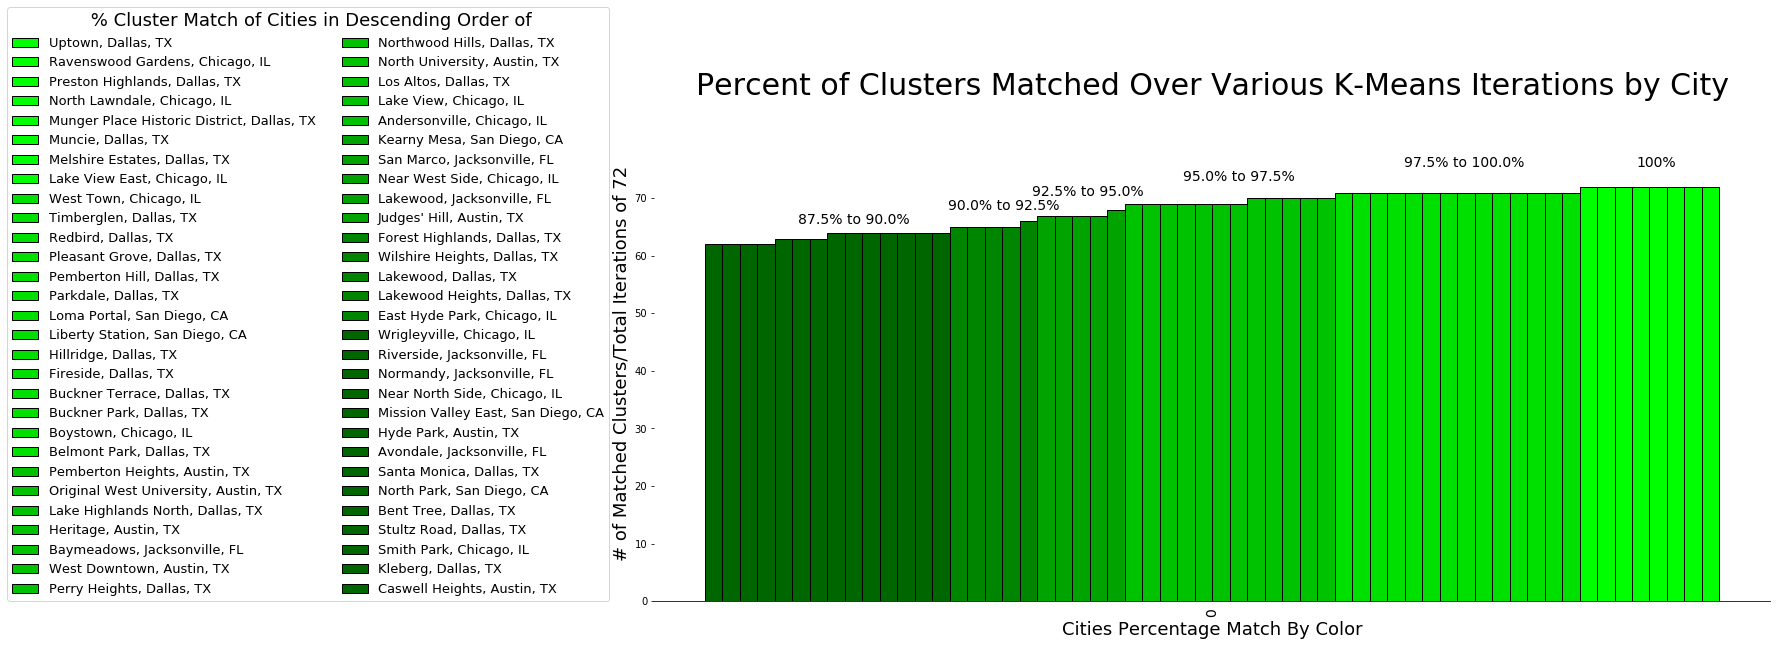

In [1256]:
#Prepare for unstacked bar plot using artists layer.

# This plot will show the percentage of time each city showed up in the predictive KMeans
# Cluster. The plot is for those that appeared 87.5% or more which is 58 of 72 total 
# output clusters or greater.

ax = test_frame.plot(
    kind='bar',
    figsize=(20, 8),
    stacked=False,
    color=colors_plt,
    width=5,
    edgecolor=['black']*len(test_frame))

#Turn of spines of plot off on all side.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)

#Plot annotation locations for percentages above bars.

i = -2.7     # Adjustment to center bar annotations
j=0          # Counter to obtain appropriate annot_list item

values_series_set=[87.5, 90.0, 92.5, 95.0, 97.5, 100] # List for annotation values
# Loop to find x and Y values for barplot annotations above bars
for items in values_series_set:
    if items != 100.0:
        plt.annotate(str(items)+'%'+' to '+str(items+2.5)+'%',
                     xy = (i+((annot_list[j]/2.)*.094),
                           items-22.0),
                     fontsize=14)
        i = (i + annot_list[j]*.083)
        j+=1
    else:   # For 100% value
        plt.annotate(str(items)+'%',
                     xy = (i+.25+((annot_list[j]/2.)*.098),
                           items-24.5),
                     fontsize=14)
        i = (i + annot_list[j]*.072)
        j+=1

#Set Tick Parameters to remove any extraneous information
ax.tick_params(
    axis='x',          # Changes apply to the x-axis
    which='both',      # Both major and minor ticks are affected
    left=False,        # Ticks along the bottom edge are off
    top=False,         # Ticks along the top edge are off
    bottom=False,      # Ticks along bottom are off
    labelleft=True,
    labelsize=14)      # Set Label and font size for y-axis
                                             
#create legend setting location, font, title, title_font, and anchor
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],
          title=' % Cluster Match of Cities in Descending Order of',
          title_fontsize = 18, 
          bbox_to_anchor=(-.31, -.015),
          loc='lower center',
          ncol=2, fontsize=13, fancybox=True)

# Setting title, x-axis label, and y-axis label as well as postion
plt.title("Percent of Clusters Matched Over Various K-Means Iterations by City",
          fontsize=30, y=1.15)
plt.xlabel("Cities Percentage Match By Color",
           fontsize=18)
plt.ylabel("# of Matched Clusters/Total Iterations of 72", horizontalalignment='right',
           y=1, fontsize=18 )

In [742]:
#final_list = []
#for i in range(len(sorted_ideal_home_dict)):
#    if sorted_ideal_home_dict[i][1] >= 61:
#        final_list.append(sorted_ideal_home_dict[i][0])

In [1163]:
final_list_df = pd.DataFrame(columns_list, columns=['Neighborhood'])

In [1164]:
# Build a Demographics DataFrame by concatenating cities matching cluster prediction match
# Over 85%.
pd_final= pd.DataFrame(columns=chicago_filtered.columns) #DF with columns from a previous
                                                         #DF with Demographics

for i in range(len(final_list_df)):         #Iteration over cities in list
                                            #and matching with each demograpics DF then
                                            #appending to new DF.
            
    temp_df = chicago_filtered.loc[chicago_filtered['Neighborhood']==          #Chicago
                                   final_list_df['Neighborhood'][i]]
    
    pd_final = pd.concat([pd_final, temp_df])
    temp_df = austin_filtered.loc[austin_filtered['Neighborhood']==             #Austin
                                  final_list_df['Neighborhood'][i]]
    
    pd_final = pd.concat([pd_final, temp_df])
    temp_df = dallas_filtered.loc[dallas_filtered['Neighborhood']==             #Dallas
                                  final_list_df['Neighborhood'][i]]
    
    pd_final = pd.concat([pd_final, temp_df])
    temp_df = jacksonville_filtered.loc[jacksonville_filtered['Neighborhood']== #Jacksonville
                                        final_list_df['Neighborhood'][i]]
    
    pd_final = pd.concat([pd_final, temp_df])
    temp_df = san_diego_filtered.loc[san_diego_filtered['Neighborhood']==       #San Diego
                                     final_list_df['Neighborhood'][i]]
    
    pd_final = pd.concat([pd_final, temp_df])
    

pd_final.head()

,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
13,"Caswell Heights, Austin, TX",30.307765,-97.719435,78751,29779,18,160.5,78,23.5,80,25.9,1,3.6,1,55.3,96,49.7,92,13829,64,1.8,0,28.1,3,122.2,97,27.6,0,10.4,64,67.3,22,1.5,50,6.8,93,21.6,90
108,"Kleberg, Dallas, TX",32.814746,-96.812848,75219,38588,49,164.2,79,19.6,28,23.6,1,3.4,1,38.0,87,39.2,81,22682,78,2.0,2,31.9,12,152.3,98,36.0,2,10.5,65,41.4,9,8.0,74,6.9,93,41.4,95
7,"Smith Park, Chicago, IL",41.921661,-87.658338,60614,68324,92,383.3,97,18.0,7,40.3,4,3.9,2,78.4,99,66.1,99,65438,99,1.7,0,31.0,9,97.2,74,34.7,1,7.5,22,85.1,42,4.1,64,3.6,87,5.3,71
2,"Stultz Road, Dallas, TX",32.869628,-96.793932,75225,98838,98,485.0,98,21.0,49,76.9,49,6.8,94,74.9,99,66.0,99,20157,74,2.3,14,41.7,88,78.4,3,65.6,77,7.9,28,95.9,72,0.0,5,0.7,58,2.2,53
12,"Bent Tree, Dallas, TX",32.979902,-96.815513,75248,69809,93,203.9,87,19.7,29,56.8,12,5.8,67,58.5,97,54.7,95,33211,89,2.1,4,41.2,86,92.3,50,59.7,41,13.1,91,81.8,37,3.5,62,6.1,92,6.6,75


In [1250]:
#Sort Descending on 'Median Income' and Limiting COst Of Living Index to less than 400
pd_final_sorted = pd_final.sort_values('MedianIncome', ascending=False)
pd_final_sorted_coli = pd_final_sorted.loc[
    pd_final_sorted[
        'CostOfLivingIndex']<400].sort_values(
    'MedianIncome',ascending = False
).reset_index(drop=True).head(10)
pd_final_sorted_coli

,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Bent Tree, Dallas, TX",32.979902,-96.815513,75248,69809,93,203.9,87,19.7,29,56.8,12,5.8,67,58.5,97,54.7,95,33211,89,2.1,4,41.2,86,92.3,50,59.7,41,13.1,91,81.8,37,3.5,62,6.1,92,6.6,75
1,"North Lawndale, Chicago, IL",41.916083,-87.648442,60614,68324,92,383.3,97,18.0,7,40.3,4,3.9,2,78.4,99,66.1,99,65438,99,1.7,0,31.0,9,97.2,74,34.7,1,7.5,22,85.1,42,4.1,64,3.6,87,5.3,71
2,"Ravenswood Gardens, Chicago, IL",41.915128,-87.652836,60614,68324,92,383.3,97,18.0,7,40.3,4,3.9,2,78.4,99,66.1,99,65438,99,1.7,0,31.0,9,97.2,74,34.7,1,7.5,22,85.1,42,4.1,64,3.6,87,5.3,71
3,"Smith Park, Chicago, IL",41.921661,-87.658338,60614,68324,92,383.3,97,18.0,7,40.3,4,3.9,2,78.4,99,66.1,99,65438,99,1.7,0,31.0,9,97.2,74,34.7,1,7.5,22,85.1,42,4.1,64,3.6,87,5.3,71
4,"Bent Tree, Dallas, TX",32.894961,-96.817753,75229,64067,90,186.6,84,19.7,29,74.6,41,6.6,92,42.2,90,41.7,85,30994,87,2.7,72,37.3,52,96.5,71,62.9,60,8.0,29,58.9,17,4.2,64,2.5,82,33.2,94
5,"Forest Highlands, Dallas, TX",32.987682,-96.801749,75252,58257,85,212.5,89,20.7,45,40.2,4,4.1,3,60.8,97,55.6,96,22557,78,1.9,1,33.2,17,100.0,83,51.2,14,12.7,88,72.0,26,5.9,70,12.8,97,6.7,75
6,"Lakewood, Dallas, TX",32.979672,-96.763734,75080,55973,83,134.9,69,19.9,33,60.0,15,5.7,61,46.2,92,49.1,92,43244,95,2.5,46,35.6,34,90.0,37,58.9,37,9.8,56,72.7,26,4.7,66,6.8,93,13.2,85
7,"Lake View, Chicago, IL",41.939781,-87.658927,60657,55647,83,306.2,95,20.1,36,30.3,2,3.9,2,72.7,99,63.9,98,66828,99,1.6,0,30.9,9,104.0,90,29.0,0,7.2,18,82.3,37,3.4,61,5.0,91,7.5,77
8,"Lake View East, Chicago, IL",41.939972,-87.649275,60657,55647,83,306.2,95,20.1,36,30.3,2,3.9,2,72.7,99,63.9,98,66828,99,1.6,0,30.9,9,104.0,90,29.0,0,7.2,18,82.3,37,3.4,61,5.0,91,7.5,77
9,"Boystown, Chicago, IL",41.943998,-87.647385,60657,55647,83,306.2,95,20.1,36,30.3,2,3.9,2,72.7,99,63.9,98,66828,99,1.6,0,30.9,9,104.0,90,29.0,0,7.2,18,82.3,37,3.4,61,5.0,91,7.5,77


In [1213]:
pd_final_sorted.reset_index(drop='True', inplace=True)
pd_final_sorted.head()

,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Uptown, Dallas, TX",32.868538,-96.773511,75225,98838,98,485.0,98,21.0,49,76.9,49,6.8,94,74.9,99,66.0,99,20157,74,2.3,14,41.7,88,78.4,3,65.6,77,7.9,28,95.9,72,0.0,5,0.7,58,2.2,53
1,"Stultz Road, Dallas, TX",32.869628,-96.793932,75225,98838,98,485.0,98,21.0,49,76.9,49,6.8,94,74.9,99,66.0,99,20157,74,2.3,14,41.7,88,78.4,3,65.6,77,7.9,28,95.9,72,0.0,5,0.7,58,2.2,53
2,"Northwood Hills, Dallas, TX",32.863998,-96.803733,75225,98838,98,485.0,98,21.0,49,76.9,49,6.8,94,74.9,99,66.0,99,20157,74,2.3,14,41.7,88,78.4,3,65.6,77,7.9,28,95.9,72,0.0,5,0.7,58,2.2,53
3,"Fireside, Dallas, TX",32.823208,-96.788941,75205,73153,94,631.3,99,21.8,60,51.6,9,5.3,33,73.0,99,60.7,98,24156,80,2.4,27,32.5,14,87.7,26,45.5,7,8.6,37,89.1,49,1.5,50,2.1,79,5.9,73
4,"Lake Highlands North, Dallas, TX",32.833461,-96.791945,75205,73153,94,631.3,99,21.8,60,51.6,9,5.3,33,73.0,99,60.7,98,24156,80,2.4,27,32.5,14,87.7,26,45.5,7,8.6,37,89.1,49,1.5,50,2.1,79,5.9,73


In [1260]:
full_pd=pd.DataFrame()
for i in range(len(pd_final_sorted_coli)):
                  pd_temp =  venues_merged.loc[
                      venues_merged['Neighborhood']== pd_final_sorted_coli['Neighborhood'][i]
                  ]
                  full_pd = pd.concat([full_pd, pd_temp])
full_pd.reset_index(drop=True, inplace=True)
full_pd.head()

,Cluster Labels,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,29,"Bent Tree, Dallas, TX",32.979902,-96.815513,Bank,Mexican Restaurant,Sandwich Place,Shipping Store,Intersection,Italian Restaurant,Burger Joint,Pizza Place,Gym / Fitness Center,Spa
1,21,"North Lawndale, Chicago, IL",41.858978,-87.715202,Cosmetics Shop,Sushi Restaurant,Italian Restaurant,Spa,Theater,Dessert Shop,Coffee Shop,Boutique,Bar,American Restaurant
2,29,"Ravenswood Gardens, Chicago, IL",41.964741,-87.693858,Furniture / Home Store,Cosmetics Shop,Spa,Clothing Store,Italian Restaurant,Sushi Restaurant,Dessert Shop,Bakery,Coffee Shop,Gym
3,29,"Smith Park, Chicago, IL",41.893383,-87.689545,Sandwich Place,Yoga Studio,Spa,Bar,Diner,Gym / Fitness Center,Gym,Restaurant,Coffee Shop,Hot Dog Joint
4,29,"Bent Tree, Dallas, TX",32.979902,-96.815513,Bank,Mexican Restaurant,Sandwich Place,Shipping Store,Intersection,Italian Restaurant,Burger Joint,Pizza Place,Gym / Fitness Center,Spa


In [1262]:
pd_final_final

,Neighborhood_x,Latitude_x,Longitude_x,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Bent Tree, Dallas, TX",32.979902,-96.815513,Bank,Mexican Restaurant,Sandwich Place,Shipping Store,Intersection,Italian Restaurant,Burger Joint,Pizza Place,Gym / Fitness Center,Spa,75248,69809,93,203.9,87,19.7,29,56.8,12,5.8,67,58.5,97,54.7,95,33211,89,2.1,4,41.2,86,92.3,50,59.7,41,13.1,91,81.8,37,3.5,62,6.1,92,6.6,75
1,"North Lawndale, Chicago, IL",41.858978,-87.715202,Cosmetics Shop,Sushi Restaurant,Italian Restaurant,Spa,Theater,Dessert Shop,Coffee Shop,Boutique,Bar,American Restaurant,60614,68324,92,383.3,97,18.0,7,40.3,4,3.9,2,78.4,99,66.1,99,65438,99,1.7,0,31.0,9,97.2,74,34.7,1,7.5,22,85.1,42,4.1,64,3.6,87,5.3,71
2,"Ravenswood Gardens, Chicago, IL",41.964741,-87.693858,Furniture / Home Store,Cosmetics Shop,Spa,Clothing Store,Italian Restaurant,Sushi Restaurant,Dessert Shop,Bakery,Coffee Shop,Gym,60614,68324,92,383.3,97,18.0,7,40.3,4,3.9,2,78.4,99,66.1,99,65438,99,1.7,0,31.0,9,97.2,74,34.7,1,7.5,22,85.1,42,4.1,64,3.6,87,5.3,71
3,"Smith Park, Chicago, IL",41.893383,-87.689545,Sandwich Place,Yoga Studio,Spa,Bar,Diner,Gym / Fitness Center,Gym,Restaurant,Coffee Shop,Hot Dog Joint,60614,68324,92,383.3,97,18.0,7,40.3,4,3.9,2,78.4,99,66.1,99,65438,99,1.7,0,31.0,9,97.2,74,34.7,1,7.5,22,85.1,42,4.1,64,3.6,87,5.3,71
4,"Bent Tree, Dallas, TX",32.979902,-96.815513,Bank,Mexican Restaurant,Sandwich Place,Shipping Store,Intersection,Italian Restaurant,Burger Joint,Pizza Place,Gym / Fitness Center,Spa,75229,64067,90,186.6,84,19.7,29,74.6,41,6.6,92,42.2,90,41.7,85,30994,87,2.7,72,37.3,52,96.5,71,62.9,60,8.0,29,58.9,17,4.2,64,2.5,82,33.2,94
5,"Forest Highlands, Dallas, TX",32.908725,-96.719432,Mexican Restaurant,Gym / Fitness Center,American Restaurant,Coffee Shop,Bank,Nail Salon,French Restaurant,Sandwich Place,Pizza Place,Convenience Store,75252,58257,85,212.5,89,20.7,45,40.2,4,4.1,3,60.8,97,55.6,96,22557,78,1.9,1,33.2,17,100.0,83,51.2,14,12.7,88,72.0,26,5.9,70,12.8,97,6.7,75
6,"Lakewood, Dallas, TX",32.834550,-96.742805,Mexican Restaurant,Sporting Goods Shop,American Restaurant,Trail,Grocery Store,Soccer Field,Sandwich Place,Restaurant,Bakery,Dessert Shop,75080,55973,83,134.9,69,19.9,33,60.0,15,5.7,61,46.2,92,49.1,92,43244,95,2.5,46,35.6,34,90.0,37,58.9,37,9.8,56,72.7,26,4.7,66,6.8,93,13.2,85
7,"Lake View, Chicago, IL",41.939781,-87.658927,Pizza Place,Performing Arts Venue,Sports Bar,Music Venue,Gym / Fitness Center,Bakery,Fish & Chips Shop,Japanese Restaurant,Sandwich Place,Martial Arts Dojo,60657,55647,83,306.2,95,20.1,36,30.3,2,3.9,2,72.7,99,63.9,98,66828,99,1.6,0,30.9,9,104.0,90,29.0,0,7.2,18,82.3,37,3.4,61,5.0,91,7.5,77
8,"Lake View East, Chicago, IL",41.939972,-87.649275,Coffee Shop,Sandwich Place,Sushi Restaurant,Japanese Restaurant,Spa,Vegetarian / Vegan Restaurant,Gay Bar,Bakery,Café,Diner,60657,55647,83,306.2,95,20.1,36,30.3,2,3.9,2,72.7,99,63.9,98,66828,99,1.6,0,30.9,9,104.0,90,29.0,0,7.2,18,82.3,37,3.4,61,5.0,91,7.5,77
9,"Boystown, Chicago, IL",41.943998,-87.647385,Gay Bar,Sushi Restaurant,Mexican Restaurant,Spa,Japanese Restaurant,Coffee Shop,New American Restaurant,Italian Restaurant,BBQ Joint,Dive Bar,60657,55647,83,306.2,95,20.1,36,30.3,2,3.9,2,72.7,99,63.9,98,66828,99,1.6,0,30.